# 2. Read and Prepare the Dataset

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [7]:
data_path = "PQEvents_Ticket_csv.csv" #@param {type:"string"}
text_column_name = "Details" #@param {type:"string"}
label_column_name = "Cause" #@param {type:"string"}

model_name = "distilbert-base-uncased" #@param {type:"string"}
test_size = 0.2 #@param {type:"number"}
num_labels = 2 #@param {type:"number"}

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.head()

,id,SiteName,FeederId,EventId,Phase,First Event,Last Event,Cause,Weather,Isolation Equipment Code,Failed Equipment Code,Details
0,1,Site0006,F_0000041,3042,4,39:06.0,39:06.0,Equipment,Unknown,Fuse,Other,"Equipment, Device UG, Damaged."
1,2,Site0012,F_0000037,3048,3,29:36.0,29:51.0,Equipment,Unknown,Breaker,Capacitor,"Equipment, Capacitor Station, Damaged."
2,3,Site0006,F_0000041,3067,2,10:46.0,10:46.0,Weather,Wind,Breaker,No Damage,"Undetermined, Wind / Weather Related."
3,4,Site0012,F_0000037,3127,2,33:30.0,33:30.0,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."
4,6,Site0006,F_0000041,3152,2,39:58.0,39:58.0,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."


In [10]:
# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])] # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])


# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")



Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)


### Clean Dataset

In [11]:
df.head()

,id,SiteName,FeederId,EventId,Phase,First Event,Last Event,Cause,Weather,Isolation Equipment Code,Failed Equipment Code,Details
0,1,Site0006,F_0000041,3042,4,39:06.0,39:06.0,Equipment,Unknown,Fuse,Other,equipment device ug damaged
1,2,Site0012,F_0000037,3048,3,29:36.0,29:51.0,Equipment,Unknown,Breaker,Capacitor,equipment capacitor station damaged
2,3,Site0006,F_0000041,3067,2,10:46.0,10:46.0,Weather,Wind,Breaker,No Damage,undetermined wind weather related
3,4,Site0012,F_0000037,3127,2,33:30.0,33:30.0,Equipment,Unknown,Fuse,Transformer,equipment transformer ug damaged
4,6,Site0006,F_0000041,3152,2,39:58.0,39:58.0,Equipment,Unknown,Fuse,Transformer,equipment transformer ug damaged


### Label Encoder

In [102]:
from sklearn import preprocessing

In [103]:
# Update labels to include both Cause and Isolation Equipment Code
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

In [104]:
# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14


In [105]:
df.head(20)

,id,SiteName,FeederId,EventId,Phase,First Event,Last Event,Cause,Weather,Isolation Equipment Code,Failed Equipment Code,Details,label,text_cleaned,cause_label,isolation_label
0,1,Site0006,F_0000041,3042,4,39:06.0,39:06.0,Equipment,Unknown,Fuse,Other,equipment device ug damaged,2,equipment device ug damaged,2,4
1,2,Site0012,F_0000037,3048,3,29:36.0,29:51.0,Equipment,Unknown,Breaker,Capacitor,equipment capacitor station damaged,2,equipment capacitor station damaged,2,0
2,3,Site0006,F_0000041,3067,2,10:46.0,10:46.0,Weather,Wind,Breaker,No Damage,undetermined wind weather related,8,undetermined wind weather related,8,0
3,4,Site0012,F_0000037,3127,2,33:30.0,33:30.0,Equipment,Unknown,Fuse,Transformer,equipment transformer ug damaged,2,equipment transformer ug damaged,2,4
4,6,Site0006,F_0000041,3152,2,39:58.0,39:58.0,Equipment,Unknown,Fuse,Transformer,equipment transformer ug damaged,2,equipment transformer ug damaged,2,4
5,7,Site0006,F_0000039,3153,6,46:21.0,46:21.0,Vehicle,Unknown,Fuse,Pole,motor vehicle pole oh down,7,motor vehicle pole oh down,7,4
6,8,Site0012,F_0000037,3162,7,24:53.0,25:33.0,Vehicle,Unknown,Breaker,Pole,motor vehicle pole oh contact,7,motor vehicle pole oh contact,7,0
7,9,Site0012,F_0000037,3163,7,24:53.0,25:33.0,Vehicle,Unknown,Breaker,Pole,motor vehicle pole oh contact,7,motor vehicle pole oh contact,7,0
8,10,Site0012,F_0000037,3164,7,24:53.0,25:33.0,Vehicle,Unknown,Breaker,Pole,motor vehicle pole oh contact,7,motor vehicle pole oh contact,7,0
9,12,Site0012,F_0000037,3166,7,24:53.0,25:33.0,Vehicle,Unknown,Breaker,Pole,motor vehicle pole oh contact,7,motor vehicle pole oh contact,7,0


In [106]:
df['text_cleaned'] = df[text_column_name]

In [107]:
# Assuming df is your DataFrame and label_column_name is the name of the column containing the labels
label_column_name1 = "Cause"  # Replace with your actual column name
label_column_name2 = "Isolation Equipment Code"  # Replace with your actual column name

# Count the number of data points for each cause
cause_counts = df[label_column_name1].value_counts()
code_counts = df[label_column_name2].value_counts()

# Print the counts
print(cause_counts)
print()
print(code_counts)

Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

Isolation Equipment Code
Breaker             76
Fuse                19
Sectionalizer       15
Recloser            13
R100-4E             13
CO15                12
CO15LB               7
R-OVR-1PT            6
Customer             5
Switch               4
SECT200NLB           4
Service Restorer     1
Fuse CO15            1
OCB                  1
R100E                1
Name: count, dtype: int64


### Train/Test Split

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
df_train,df_test = train_test_split(df,test_size=test_size)

### Convert to Huggingface Dataset

In [110]:
from datasets import Dataset

In [111]:
train_dataset = Dataset.from_dict({
    'text': df_train['text_cleaned'],
    'cause_label': df_train['cause_label'],
    'isolation_label': df_train['isolation_label']
})

test_dataset = Dataset.from_dict({
    'text': df_test['text_cleaned'], 
    'cause_label': df_test['cause_label'],
    'isolation_label': df_test['isolation_label']
})

### Tokenizer

In [112]:
from transformers import AutoTokenizer

In [113]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]  # Changed from cause_label to labels
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]  # Changed from isolation_label to labels
    return tokenized


In [114]:
tokenized_train_cause = train_dataset.map(
    preprocess_function_cause,
    batched=True,
    remove_columns=train_dataset.column_names
)

tokenized_test_cause = test_dataset.map(
    preprocess_function_cause,
    batched=True,
    remove_columns=test_dataset.column_names
)

tokenized_train_isolation = train_dataset.map(
    preprocess_function_isolation,
    batched=True,
    remove_columns=train_dataset.column_names
)

tokenized_test_isolation = test_dataset.map(
    preprocess_function_isolation,
    batched=True,
    remove_columns=test_dataset.column_names
)

Map: 100%|██████████| 36/36 [00:00<?, ? examples/s]


Map: 100%|██████████| 36/36 [00:00<00:00, 6359.29 examples/s]


In [115]:
import pandas as pd

# Assuming df is your DataFrame and label_column_name is the name of the column containing the labels
num_labels = df[label_column_name].nunique()
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 9


# 3. Initialize Model

In [116]:
from transformers import AutoModelForSequenceClassification

In [117]:
# Create separate models for cause and isolation
cause_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(le_cause.classes_)
)

isolation_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",  # Use base model instead of saved checkpoint
    num_labels=len(le_isolation.classes_)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 4. Train model

In [118]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

In [119]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [120]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Split logits and labels for each task
    cause_logits, isolation_logits = logits
    cause_labels, isolation_labels = labels
    
    # Calculate predictions
    cause_predictions = np.argmax(cause_logits, axis=-1)
    isolation_predictions = np.argmax(isolation_logits, axis=-1)
    
    # Calculate metrics for both tasks
    return {
        'cause_accuracy': metric.compute(predictions=cause_predictions, references=cause_labels)['accuracy'],
        'isolation_accuracy': metric.compute(predictions=isolation_predictions, references=isolation_labels)['accuracy']
    }

In [123]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
    # Removed label_names as it's not needed
)

cause_trainer = Trainer(
    model=cause_model,
    args=training_args,
    train_dataset=tokenized_train_cause,  # Changed from tokenized_train
    eval_dataset=tokenized_test_cause,    # Changed from tokenized_test
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: {'accuracy': metric.compute(predictions=np.argmax(x.predictions, axis=1), references=x.label_ids)['accuracy']}
)

isolation_trainer = Trainer(
    model=isolation_model,
    args=training_args,
    train_dataset=tokenized_train_isolation,  # Changed from tokenized_train 
    eval_dataset=tokenized_test_isolation,    # Changed from tokenized_test
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: {'accuracy': metric.compute(predictions=np.argmax(x.predictions, axis=1), references=x.label_ids)['accuracy']}
)


C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_14376\3199184418.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  cause_trainer = Trainer(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_14376\3199184418.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  isolation_trainer = Trainer(


In [124]:
# Train the models separately
print("Training Cause Model:")
cause_trainer.train()
print("\nTraining Isolation Model:")
isolation_trainer.train()

  0%|          | 0/1800 [05:41<?, ?it/s]


Training Cause Model:


  1%|          | 18/1800 [00:11<17:54,  1.66it/s]

{'loss': 0.1099, 'grad_norm': 0.0013521334622055292, 'learning_rate': 0.00019800000000000002, 'epoch': 1.0}







                                       
                                                 
  1%|          | 18/1800 [00:11<17:54,  1.66it/s]


{'eval_loss': 5.7811641454463825e-05, 'eval_accuracy': 1.0, 'eval_runtime': 0.411, 'eval_samples_per_second': 87.602, 'eval_steps_per_second': 12.167, 'epoch': 1.0}


  2%|▏         | 36/1800 [00:23<20:13,  1.45it/s]

{'loss': 0.1221, 'grad_norm': 0.03399481624364853, 'learning_rate': 0.000196, 'epoch': 2.0}






                                                 

  2%|▏         | 36/1800 [00:24<20:13,  1.45it/s]



{'eval_loss': 0.196052685379982, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.522, 'eval_samples_per_second': 68.967, 'eval_steps_per_second': 9.579, 'epoch': 2.0}


  3%|▎         | 54/1800 [00:35<18:05,  1.61it/s]

{'loss': 0.0585, 'grad_norm': 53.559974670410156, 'learning_rate': 0.000194, 'epoch': 3.0}






                                                 

  3%|▎         | 54/1800 [00:35<18:05,  1.61it/s]



{'eval_loss': 7.884099613875151e-05, 'eval_accuracy': 1.0, 'eval_runtime': 0.4219, 'eval_samples_per_second': 85.333, 'eval_steps_per_second': 11.852, 'epoch': 3.0}


  4%|▍         | 72/1800 [00:47<19:22,  1.49it/s]

{'loss': 0.1307, 'grad_norm': 0.0026563669089227915, 'learning_rate': 0.000192, 'epoch': 4.0}






                                                 

  4%|▍         | 72/1800 [00:47<19:22,  1.49it/s]



{'eval_loss': 0.005142631009221077, 'eval_accuracy': 1.0, 'eval_runtime': 0.4657, 'eval_samples_per_second': 77.298, 'eval_steps_per_second': 10.736, 'epoch': 4.0}


  5%|▌         | 90/1800 [01:02<22:19,  1.28it/s]

{'loss': 0.2633, 'grad_norm': 0.24170008301734924, 'learning_rate': 0.00019, 'epoch': 5.0}






                                                 

  5%|▌         | 90/1800 [01:03<22:19,  1.28it/s]



{'eval_loss': 0.006675666198134422, 'eval_accuracy': 1.0, 'eval_runtime': 0.5819, 'eval_samples_per_second': 61.863, 'eval_steps_per_second': 8.592, 'epoch': 5.0}


  6%|▌         | 108/1800 [01:16<19:42,  1.43it/s]

{'loss': 0.0864, 'grad_norm': 1.0459975004196167, 'learning_rate': 0.000188, 'epoch': 6.0}






                                                  

  6%|▌         | 108/1800 [01:16<19:42,  1.43it/s]



{'eval_loss': 0.0018996016588062048, 'eval_accuracy': 1.0, 'eval_runtime': 0.4808, 'eval_samples_per_second': 74.879, 'eval_steps_per_second': 10.4, 'epoch': 6.0}


  7%|▋         | 126/1800 [01:29<18:12,  1.53it/s]

{'loss': 0.1061, 'grad_norm': 0.010090640746057034, 'learning_rate': 0.00018600000000000002, 'epoch': 7.0}






                                                  

  7%|▋         | 126/1800 [01:29<18:12,  1.53it/s]



{'eval_loss': 1.8390634059906006, 'eval_accuracy': 0.8611111111111112, 'eval_runtime': 0.4552, 'eval_samples_per_second': 79.08, 'eval_steps_per_second': 10.983, 'epoch': 7.0}


  8%|▊         | 144/1800 [01:41<16:16,  1.70it/s]

{'loss': 0.117, 'grad_norm': 0.005111175123602152, 'learning_rate': 0.00018400000000000003, 'epoch': 8.0}






                                                  

  8%|▊         | 144/1800 [01:41<16:16,  1.70it/s]



{'eval_loss': 0.23545680940151215, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4136, 'eval_samples_per_second': 87.033, 'eval_steps_per_second': 12.088, 'epoch': 8.0}


  9%|▉         | 162/1800 [01:53<17:12,  1.59it/s]

{'loss': 0.1161, 'grad_norm': 0.25934064388275146, 'learning_rate': 0.000182, 'epoch': 9.0}





                                                  

  9%|▉         | 162/1800 [01:53<17:12,  1.59it/s]



{'eval_loss': 0.00015811249613761902, 'eval_accuracy': 1.0, 'eval_runtime': 0.3824, 'eval_samples_per_second': 94.154, 'eval_steps_per_second': 13.077, 'epoch': 9.0}


 10%|█         | 180/1800 [02:04<16:16,  1.66it/s]

{'loss': 0.0535, 'grad_norm': 0.2971203327178955, 'learning_rate': 0.00018, 'epoch': 10.0}






                                                  

 10%|█         | 180/1800 [02:05<16:16,  1.66it/s]



{'eval_loss': 0.0010638860985636711, 'eval_accuracy': 1.0, 'eval_runtime': 0.4169, 'eval_samples_per_second': 86.351, 'eval_steps_per_second': 11.993, 'epoch': 10.0}


 11%|█         | 198/1800 [02:16<16:04,  1.66it/s]

{'loss': 0.0034, 'grad_norm': 0.0010959183564409614, 'learning_rate': 0.00017800000000000002, 'epoch': 11.0}





                                                  

 11%|█         | 198/1800 [02:17<16:04,  1.66it/s]



{'eval_loss': 0.43510520458221436, 'eval_accuracy': 0.9444444444444444, 'eval_runtime': 0.4169, 'eval_samples_per_second': 86.354, 'eval_steps_per_second': 11.994, 'epoch': 11.0}


 12%|█▏        | 216/1800 [02:28<16:09,  1.63it/s]

{'loss': 0.0841, 'grad_norm': 0.0036443988792598248, 'learning_rate': 0.00017600000000000002, 'epoch': 12.0}






                                                  

 12%|█▏        | 216/1800 [02:28<16:09,  1.63it/s]



{'eval_loss': 0.19412797689437866, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4345, 'eval_samples_per_second': 82.85, 'eval_steps_per_second': 11.507, 'epoch': 12.0}


 13%|█▎        | 234/1800 [02:40<16:07,  1.62it/s]

{'loss': 0.0002, 'grad_norm': 0.0012582020135596395, 'learning_rate': 0.000174, 'epoch': 13.0}






                                                  

 13%|█▎        | 234/1800 [02:40<16:07,  1.62it/s]



{'eval_loss': 0.0352422297000885, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4131, 'eval_samples_per_second': 87.146, 'eval_steps_per_second': 12.104, 'epoch': 13.0}


 14%|█▍        | 252/1800 [02:52<16:24,  1.57it/s]

{'loss': 0.0001, 'grad_norm': 0.0008650608942843974, 'learning_rate': 0.000172, 'epoch': 14.0}






                                                  

 14%|█▍        | 252/1800 [02:52<16:24,  1.57it/s]



{'eval_loss': 0.01576685532927513, 'eval_accuracy': 1.0, 'eval_runtime': 0.429, 'eval_samples_per_second': 83.917, 'eval_steps_per_second': 11.655, 'epoch': 14.0}


 15%|█▌        | 270/1800 [03:05<16:57,  1.50it/s]

{'loss': 0.0001, 'grad_norm': 0.006571079138666391, 'learning_rate': 0.00017, 'epoch': 15.0}






                                                  

 15%|█▌        | 270/1800 [03:05<16:57,  1.50it/s]



{'eval_loss': 0.020974833518266678, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4529, 'eval_samples_per_second': 79.48, 'eval_steps_per_second': 11.039, 'epoch': 15.0}


 16%|█▌        | 288/1800 [03:17<16:06,  1.56it/s]

{'loss': 0.0001, 'grad_norm': 0.000535046448931098, 'learning_rate': 0.000168, 'epoch': 16.0}






                                                  

 16%|█▌        | 288/1800 [03:18<16:06,  1.56it/s]



{'eval_loss': 0.056508276611566544, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4231, 'eval_samples_per_second': 85.081, 'eval_steps_per_second': 11.817, 'epoch': 16.0}


 17%|█▋        | 306/1800 [03:30<16:42,  1.49it/s]

{'loss': 0.0, 'grad_norm': 0.0012739560334011912, 'learning_rate': 0.000166, 'epoch': 17.0}






                                                  

 17%|█▋        | 306/1800 [03:30<16:42,  1.49it/s]



{'eval_loss': 0.09830635786056519, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4239, 'eval_samples_per_second': 84.917, 'eval_steps_per_second': 11.794, 'epoch': 17.0}


 18%|█▊        | 324/1800 [03:42<15:10,  1.62it/s]

{'loss': 0.0001, 'grad_norm': 0.0018963494803756475, 'learning_rate': 0.000164, 'epoch': 18.0}






                                                  

 18%|█▊        | 324/1800 [03:42<15:10,  1.62it/s]



{'eval_loss': 0.10692494362592697, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.5175, 'eval_samples_per_second': 69.56, 'eval_steps_per_second': 9.661, 'epoch': 18.0}


 19%|█▉        | 342/1800 [03:54<15:12,  1.60it/s]

{'loss': 0.0001, 'grad_norm': 0.0024557809811085463, 'learning_rate': 0.000162, 'epoch': 19.0}






                                                  

 19%|█▉        | 342/1800 [03:54<15:12,  1.60it/s]



{'eval_loss': 0.11103112250566483, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4331, 'eval_samples_per_second': 83.115, 'eval_steps_per_second': 11.544, 'epoch': 19.0}


 20%|██        | 360/1800 [04:05<14:57,  1.60it/s]

{'loss': 0.0001, 'grad_norm': 0.00037339006667025387, 'learning_rate': 0.00016, 'epoch': 20.0}






                                                  

 20%|██        | 360/1800 [04:06<14:57,  1.60it/s]



{'eval_loss': 0.11557085067033768, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4096, 'eval_samples_per_second': 87.884, 'eval_steps_per_second': 12.206, 'epoch': 20.0}


 21%|██        | 378/1800 [04:18<16:02,  1.48it/s]

{'loss': 0.0, 'grad_norm': 0.0015335099305957556, 'learning_rate': 0.00015800000000000002, 'epoch': 21.0}






                                                  

 21%|██        | 378/1800 [04:18<16:02,  1.48it/s]



{'eval_loss': 0.12031710147857666, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4418, 'eval_samples_per_second': 81.477, 'eval_steps_per_second': 11.316, 'epoch': 21.0}


 22%|██▏       | 396/1800 [04:30<14:51,  1.58it/s]

{'loss': 0.0, 'grad_norm': 0.002700302517041564, 'learning_rate': 0.00015600000000000002, 'epoch': 22.0}






                                                  

 22%|██▏       | 396/1800 [04:30<14:51,  1.58it/s]



{'eval_loss': 0.12680478394031525, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4237, 'eval_samples_per_second': 84.964, 'eval_steps_per_second': 11.801, 'epoch': 22.0}


 23%|██▎       | 414/1800 [04:42<14:36,  1.58it/s]

{'loss': 0.0, 'grad_norm': 0.0005335120367817581, 'learning_rate': 0.000154, 'epoch': 23.0}






                                                  

 23%|██▎       | 414/1800 [04:42<14:36,  1.58it/s]



{'eval_loss': 0.13250286877155304, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.423, 'eval_samples_per_second': 85.097, 'eval_steps_per_second': 11.819, 'epoch': 23.0}


 24%|██▍       | 432/1800 [04:54<14:11,  1.61it/s]

{'loss': 0.0, 'grad_norm': 0.0002325046225450933, 'learning_rate': 0.000152, 'epoch': 24.0}






                                                  

 24%|██▍       | 432/1800 [04:54<14:11,  1.61it/s]



{'eval_loss': 0.1379028856754303, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4152, 'eval_samples_per_second': 86.696, 'eval_steps_per_second': 12.041, 'epoch': 24.0}


 25%|██▌       | 450/1800 [05:06<14:32,  1.55it/s]

{'loss': 0.0, 'grad_norm': 0.00039083443698473275, 'learning_rate': 0.00015000000000000001, 'epoch': 25.0}






                                                  

 25%|██▌       | 450/1800 [05:06<14:32,  1.55it/s]



{'eval_loss': 0.14132362604141235, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4437, 'eval_samples_per_second': 81.134, 'eval_steps_per_second': 11.269, 'epoch': 25.0}


 26%|██▌       | 468/1800 [05:18<14:23,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.0002626570058055222, 'learning_rate': 0.000148, 'epoch': 26.0}






                                                  

 26%|██▌       | 468/1800 [05:19<14:23,  1.54it/s]



{'eval_loss': 0.14433161914348602, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4393, 'eval_samples_per_second': 81.95, 'eval_steps_per_second': 11.382, 'epoch': 26.0}


 27%|██▋       | 486/1800 [05:31<14:05,  1.55it/s]

{'loss': 0.0, 'grad_norm': 0.003094700863584876, 'learning_rate': 0.000146, 'epoch': 27.0}






                                                  

 27%|██▋       | 486/1800 [05:31<14:05,  1.55it/s]



{'eval_loss': 0.14744001626968384, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4314, 'eval_samples_per_second': 83.449, 'eval_steps_per_second': 11.59, 'epoch': 27.0}


 28%|██▊       | 504/1800 [05:44<15:55,  1.36it/s]

{'loss': 0.0, 'grad_norm': 0.0017002405365929008, 'learning_rate': 0.000144, 'epoch': 28.0}






                                                  

 28%|██▊       | 504/1800 [05:44<15:55,  1.36it/s]



{'eval_loss': 0.15052837133407593, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4192, 'eval_samples_per_second': 85.874, 'eval_steps_per_second': 11.927, 'epoch': 28.0}


 29%|██▉       | 522/1800 [05:56<13:28,  1.58it/s]

{'loss': 0.0, 'grad_norm': 0.00036556945997290313, 'learning_rate': 0.000142, 'epoch': 29.0}






                                                  

 29%|██▉       | 522/1800 [05:57<13:28,  1.58it/s]



{'eval_loss': 0.1537439376115799, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4226, 'eval_samples_per_second': 85.179, 'eval_steps_per_second': 11.83, 'epoch': 29.0}


 30%|███       | 540/1800 [06:08<13:28,  1.56it/s]

{'loss': 0.0, 'grad_norm': 0.0001456016761949286, 'learning_rate': 0.00014, 'epoch': 30.0}






                                                  

 30%|███       | 540/1800 [06:09<13:28,  1.56it/s]



{'eval_loss': 0.15654411911964417, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4558, 'eval_samples_per_second': 78.977, 'eval_steps_per_second': 10.969, 'epoch': 30.0}


 31%|███       | 558/1800 [06:21<13:57,  1.48it/s]

{'loss': 0.0, 'grad_norm': 0.0009481756715103984, 'learning_rate': 0.000138, 'epoch': 31.0}






                                                  

 31%|███       | 558/1800 [06:21<13:57,  1.48it/s]



{'eval_loss': 0.15894438326358795, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4719, 'eval_samples_per_second': 76.288, 'eval_steps_per_second': 10.596, 'epoch': 31.0}


 32%|███▏      | 576/1800 [06:34<14:30,  1.41it/s]

{'loss': 0.0, 'grad_norm': 0.0006470969528891146, 'learning_rate': 0.00013600000000000003, 'epoch': 32.0}






                                                  

 32%|███▏      | 576/1800 [06:35<14:30,  1.41it/s]



{'eval_loss': 0.16124169528484344, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4279, 'eval_samples_per_second': 84.126, 'eval_steps_per_second': 11.684, 'epoch': 32.0}


 33%|███▎      | 594/1800 [06:47<13:26,  1.50it/s]

{'loss': 0.0, 'grad_norm': 0.0001810486282920465, 'learning_rate': 0.000134, 'epoch': 33.0}






                                                  

 33%|███▎      | 594/1800 [06:47<13:26,  1.50it/s]



{'eval_loss': 0.16348223388195038, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4529, 'eval_samples_per_second': 79.489, 'eval_steps_per_second': 11.04, 'epoch': 33.0}


 34%|███▍      | 612/1800 [06:59<13:04,  1.51it/s]

{'loss': 0.0, 'grad_norm': 0.00019927931134589016, 'learning_rate': 0.000132, 'epoch': 34.0}






                                                  

 34%|███▍      | 612/1800 [07:00<13:04,  1.51it/s]



{'eval_loss': 0.16660860180854797, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4932, 'eval_samples_per_second': 72.987, 'eval_steps_per_second': 10.137, 'epoch': 34.0}


 35%|███▌      | 630/1800 [07:13<13:18,  1.47it/s]

{'loss': 0.0, 'grad_norm': 0.00011967439786531031, 'learning_rate': 0.00013000000000000002, 'epoch': 35.0}






                                                  

 35%|███▌      | 630/1800 [07:13<13:18,  1.47it/s]



{'eval_loss': 0.16879191994667053, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4693, 'eval_samples_per_second': 76.711, 'eval_steps_per_second': 10.654, 'epoch': 35.0}


 36%|███▌      | 648/1800 [07:26<12:44,  1.51it/s]

{'loss': 0.0, 'grad_norm': 0.00018115645798388869, 'learning_rate': 0.00012800000000000002, 'epoch': 36.0}






                                                  

 36%|███▌      | 648/1800 [07:26<12:44,  1.51it/s]



{'eval_loss': 0.17084577679634094, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4348, 'eval_samples_per_second': 82.795, 'eval_steps_per_second': 11.499, 'epoch': 36.0}


 37%|███▋      | 666/1800 [07:38<12:00,  1.57it/s]

{'loss': 0.0, 'grad_norm': 0.00023489538580179214, 'learning_rate': 0.000126, 'epoch': 37.0}






                                                  

 37%|███▋      | 666/1800 [07:38<12:00,  1.57it/s]



{'eval_loss': 0.1730571687221527, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4134, 'eval_samples_per_second': 87.081, 'eval_steps_per_second': 12.095, 'epoch': 37.0}


 38%|███▊      | 684/1800 [07:50<12:11,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00048073037760332227, 'learning_rate': 0.000124, 'epoch': 38.0}






                                                  

 38%|███▊      | 684/1800 [07:51<12:11,  1.53it/s]



{'eval_loss': 0.1750776469707489, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4042, 'eval_samples_per_second': 89.054, 'eval_steps_per_second': 12.369, 'epoch': 38.0}


 39%|███▉      | 702/1800 [08:03<11:54,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.0013323350576683879, 'learning_rate': 0.000122, 'epoch': 39.0}






                                                  

 39%|███▉      | 702/1800 [08:03<11:54,  1.54it/s]



{'eval_loss': 0.176924929022789, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.423, 'eval_samples_per_second': 85.105, 'eval_steps_per_second': 11.82, 'epoch': 39.0}


 40%|████      | 720/1800 [08:15<11:48,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00018674421880859882, 'learning_rate': 0.00012, 'epoch': 40.0}






                                                  

 40%|████      | 720/1800 [08:16<11:48,  1.52it/s]



{'eval_loss': 0.1784641295671463, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4198, 'eval_samples_per_second': 85.763, 'eval_steps_per_second': 11.911, 'epoch': 40.0}


 41%|████      | 738/1800 [08:29<14:23,  1.23it/s]

{'loss': 0.0, 'grad_norm': 8.980984421214089e-05, 'learning_rate': 0.000118, 'epoch': 41.0}






                                                  

 41%|████      | 738/1800 [08:30<14:23,  1.23it/s]



{'eval_loss': 0.18115314841270447, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4309, 'eval_samples_per_second': 83.547, 'eval_steps_per_second': 11.604, 'epoch': 41.0}


 42%|████▏     | 756/1800 [08:42<11:18,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.00014530131011269987, 'learning_rate': 0.000116, 'epoch': 42.0}






                                                  

 42%|████▏     | 756/1800 [08:42<11:18,  1.54it/s]



{'eval_loss': 0.18382370471954346, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4439, 'eval_samples_per_second': 81.091, 'eval_steps_per_second': 11.263, 'epoch': 42.0}


 43%|████▎     | 774/1800 [08:54<10:41,  1.60it/s]

{'loss': 0.0, 'grad_norm': 0.0009325639111921191, 'learning_rate': 0.00011399999999999999, 'epoch': 43.0}






                                                  

 43%|████▎     | 774/1800 [08:54<10:41,  1.60it/s]



{'eval_loss': 0.18570087850093842, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4159, 'eval_samples_per_second': 86.568, 'eval_steps_per_second': 12.023, 'epoch': 43.0}


 44%|████▍     | 792/1800 [09:06<10:51,  1.55it/s]

{'loss': 0.0, 'grad_norm': 0.0001711107906885445, 'learning_rate': 0.00011200000000000001, 'epoch': 44.0}






                                                  

 44%|████▍     | 792/1800 [09:06<10:51,  1.55it/s]



{'eval_loss': 0.18786054849624634, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.5235, 'eval_samples_per_second': 68.765, 'eval_steps_per_second': 9.551, 'epoch': 44.0}


 45%|████▌     | 810/1800 [09:18<10:48,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00011104652367066592, 'learning_rate': 0.00011000000000000002, 'epoch': 45.0}






                                                  

 45%|████▌     | 810/1800 [09:19<10:48,  1.53it/s]



{'eval_loss': 0.1890859156847, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4563, 'eval_samples_per_second': 78.897, 'eval_steps_per_second': 10.958, 'epoch': 45.0}


 46%|████▌     | 828/1800 [09:31<10:31,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.00016378135478589684, 'learning_rate': 0.00010800000000000001, 'epoch': 46.0}






                                                  

 46%|████▌     | 828/1800 [09:31<10:31,  1.54it/s]



{'eval_loss': 0.19035795331001282, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4202, 'eval_samples_per_second': 85.668, 'eval_steps_per_second': 11.898, 'epoch': 46.0}


 47%|████▋     | 846/1800 [09:43<10:10,  1.56it/s]

{'loss': 0.0, 'grad_norm': 0.001956928987056017, 'learning_rate': 0.00010600000000000002, 'epoch': 47.0}






                                                  

 47%|████▋     | 846/1800 [09:44<10:10,  1.56it/s]



{'eval_loss': 0.19171705842018127, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4172, 'eval_samples_per_second': 86.281, 'eval_steps_per_second': 11.983, 'epoch': 47.0}


 48%|████▊     | 864/1800 [09:56<10:11,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.000174201704794541, 'learning_rate': 0.00010400000000000001, 'epoch': 48.0}






                                                  

 48%|████▊     | 864/1800 [09:56<10:11,  1.53it/s]



{'eval_loss': 0.19287186861038208, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4363, 'eval_samples_per_second': 82.512, 'eval_steps_per_second': 11.46, 'epoch': 48.0}


 49%|████▉     | 882/1800 [10:08<10:00,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00012139226600993425, 'learning_rate': 0.00010200000000000001, 'epoch': 49.0}






                                                  

 49%|████▉     | 882/1800 [10:09<10:00,  1.53it/s]



{'eval_loss': 0.19418658316135406, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4348, 'eval_samples_per_second': 82.791, 'eval_steps_per_second': 11.499, 'epoch': 49.0}


 50%|█████     | 900/1800 [10:21<09:33,  1.57it/s]

{'loss': 0.0, 'grad_norm': 0.0001791545219020918, 'learning_rate': 0.0001, 'epoch': 50.0}






                                                  

 50%|█████     | 900/1800 [10:21<09:33,  1.57it/s]



{'eval_loss': 0.1954144835472107, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4339, 'eval_samples_per_second': 82.964, 'eval_steps_per_second': 11.523, 'epoch': 50.0}


 51%|█████     | 918/1800 [10:33<09:29,  1.55it/s]

{'loss': 0.0, 'grad_norm': 0.00016530801076442003, 'learning_rate': 9.8e-05, 'epoch': 51.0}






                                                  

 51%|█████     | 918/1800 [10:33<09:29,  1.55it/s]



{'eval_loss': 0.19649659097194672, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.447, 'eval_samples_per_second': 80.535, 'eval_steps_per_second': 11.185, 'epoch': 51.0}


 52%|█████▏    | 936/1800 [10:48<10:40,  1.35it/s]

{'loss': 0.0, 'grad_norm': 0.0004268248158041388, 'learning_rate': 9.6e-05, 'epoch': 52.0}






                                                  

 52%|█████▏    | 936/1800 [10:48<10:40,  1.35it/s]



{'eval_loss': 0.1975024789571762, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.5037, 'eval_samples_per_second': 71.478, 'eval_steps_per_second': 9.927, 'epoch': 52.0}


 53%|█████▎    | 954/1800 [11:03<12:12,  1.16it/s]

{'loss': 0.0, 'grad_norm': 0.00033101410372182727, 'learning_rate': 9.4e-05, 'epoch': 53.0}






                                                  

 53%|█████▎    | 954/1800 [11:03<12:12,  1.16it/s]



{'eval_loss': 0.19837133586406708, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.5655, 'eval_samples_per_second': 63.665, 'eval_steps_per_second': 8.842, 'epoch': 53.0}


 54%|█████▍    | 972/1800 [11:17<09:10,  1.50it/s]

{'loss': 0.0, 'grad_norm': 0.00013621592370327562, 'learning_rate': 9.200000000000001e-05, 'epoch': 54.0}






                                                  

 54%|█████▍    | 972/1800 [11:17<09:10,  1.50it/s]



{'eval_loss': 0.19991958141326904, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4533, 'eval_samples_per_second': 79.423, 'eval_steps_per_second': 11.031, 'epoch': 54.0}


 55%|█████▌    | 990/1800 [11:30<08:52,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00026955464272759855, 'learning_rate': 9e-05, 'epoch': 55.0}






                                                  

 55%|█████▌    | 990/1800 [11:30<08:52,  1.52it/s]



{'eval_loss': 0.20118866860866547, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4435, 'eval_samples_per_second': 81.174, 'eval_steps_per_second': 11.274, 'epoch': 55.0}


 56%|█████▌    | 1008/1800 [11:43<08:50,  1.49it/s]

{'loss': 0.0, 'grad_norm': 9.584546933183447e-05, 'learning_rate': 8.800000000000001e-05, 'epoch': 56.0}






                                                   

 56%|█████▌    | 1008/1800 [11:43<08:50,  1.49it/s]



{'eval_loss': 0.20223532617092133, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4245, 'eval_samples_per_second': 84.799, 'eval_steps_per_second': 11.778, 'epoch': 56.0}


 57%|█████▋    | 1026/1800 [11:56<08:31,  1.51it/s]

{'loss': 0.0, 'grad_norm': 0.00011114701192127541, 'learning_rate': 8.6e-05, 'epoch': 57.0}






                                                   

 57%|█████▋    | 1026/1800 [11:56<08:31,  1.51it/s]



{'eval_loss': 0.2033417820930481, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.436, 'eval_samples_per_second': 82.574, 'eval_steps_per_second': 11.469, 'epoch': 57.0}


 58%|█████▊    | 1044/1800 [12:08<08:26,  1.49it/s]

{'loss': 0.0, 'grad_norm': 0.00013552889868151397, 'learning_rate': 8.4e-05, 'epoch': 58.0}






                                                   

 58%|█████▊    | 1044/1800 [12:09<08:26,  1.49it/s]



{'eval_loss': 0.20488986372947693, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4515, 'eval_samples_per_second': 79.733, 'eval_steps_per_second': 11.074, 'epoch': 58.0}


 59%|█████▉    | 1062/1800 [12:21<08:03,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00023481664538849145, 'learning_rate': 8.2e-05, 'epoch': 59.0}






                                                   

 59%|█████▉    | 1062/1800 [12:21<08:03,  1.52it/s]



{'eval_loss': 0.20566672086715698, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4284, 'eval_samples_per_second': 84.037, 'eval_steps_per_second': 11.672, 'epoch': 59.0}


 60%|██████    | 1080/1800 [12:33<07:49,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00011073659698013216, 'learning_rate': 8e-05, 'epoch': 60.0}






                                                   

 60%|██████    | 1080/1800 [12:34<07:49,  1.53it/s]



{'eval_loss': 0.2065998911857605, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4377, 'eval_samples_per_second': 82.245, 'eval_steps_per_second': 11.423, 'epoch': 60.0}


 61%|██████    | 1098/1800 [12:46<07:35,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.0002726956154219806, 'learning_rate': 7.800000000000001e-05, 'epoch': 61.0}






                                                   

 61%|██████    | 1098/1800 [12:46<07:35,  1.54it/s]



{'eval_loss': 0.2074417769908905, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4306, 'eval_samples_per_second': 83.599, 'eval_steps_per_second': 11.611, 'epoch': 61.0}


 62%|██████▏   | 1116/1800 [12:58<07:33,  1.51it/s]

{'loss': 0.0, 'grad_norm': 0.0013176221400499344, 'learning_rate': 7.6e-05, 'epoch': 62.0}






                                                   

 62%|██████▏   | 1116/1800 [12:59<07:33,  1.51it/s]



{'eval_loss': 0.20847521722316742, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4313, 'eval_samples_per_second': 83.475, 'eval_steps_per_second': 11.594, 'epoch': 62.0}


 63%|██████▎   | 1134/1800 [13:11<07:17,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00012216626782901585, 'learning_rate': 7.4e-05, 'epoch': 63.0}






                                                   

 63%|██████▎   | 1134/1800 [13:11<07:17,  1.52it/s]



{'eval_loss': 0.20924586057662964, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4448, 'eval_samples_per_second': 80.929, 'eval_steps_per_second': 11.24, 'epoch': 63.0}


 64%|██████▍   | 1152/1800 [13:24<07:26,  1.45it/s]

{'loss': 0.0, 'grad_norm': 0.00012943369802087545, 'learning_rate': 7.2e-05, 'epoch': 64.0}






                                                   

 64%|██████▍   | 1152/1800 [13:25<07:26,  1.45it/s]



{'eval_loss': 0.20992590487003326, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.461, 'eval_samples_per_second': 78.089, 'eval_steps_per_second': 10.846, 'epoch': 64.0}


 65%|██████▌   | 1170/1800 [13:37<06:48,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.00014427107817027718, 'learning_rate': 7e-05, 'epoch': 65.0}






                                                   

 65%|██████▌   | 1170/1800 [13:37<06:48,  1.54it/s]



{'eval_loss': 0.2106749564409256, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4328, 'eval_samples_per_second': 83.174, 'eval_steps_per_second': 11.552, 'epoch': 65.0}


 66%|██████▌   | 1188/1800 [13:49<06:35,  1.55it/s]

{'loss': 0.0, 'grad_norm': 6.767958257114515e-05, 'learning_rate': 6.800000000000001e-05, 'epoch': 66.0}






                                                   

 66%|██████▌   | 1188/1800 [13:50<06:35,  1.55it/s]



{'eval_loss': 0.2115079164505005, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4394, 'eval_samples_per_second': 81.934, 'eval_steps_per_second': 11.38, 'epoch': 66.0}


 67%|██████▋   | 1206/1800 [14:01<06:30,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.0003530716057866812, 'learning_rate': 6.6e-05, 'epoch': 67.0}






                                                   

 67%|██████▋   | 1206/1800 [14:02<06:30,  1.52it/s]



{'eval_loss': 0.21210867166519165, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.428, 'eval_samples_per_second': 84.108, 'eval_steps_per_second': 11.682, 'epoch': 67.0}


 68%|██████▊   | 1224/1800 [14:14<06:18,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00030668292311020195, 'learning_rate': 6.400000000000001e-05, 'epoch': 68.0}






                                                   

 68%|██████▊   | 1224/1800 [14:15<06:18,  1.52it/s]



{'eval_loss': 0.2127646654844284, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4257, 'eval_samples_per_second': 84.566, 'eval_steps_per_second': 11.745, 'epoch': 68.0}


 69%|██████▉   | 1242/1800 [14:26<05:58,  1.56it/s]

{'loss': 0.0, 'grad_norm': 0.00012169845285825431, 'learning_rate': 6.2e-05, 'epoch': 69.0}






                                                   

 69%|██████▉   | 1242/1800 [14:27<05:58,  1.56it/s]



{'eval_loss': 0.21301931142807007, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4318, 'eval_samples_per_second': 83.37, 'eval_steps_per_second': 11.579, 'epoch': 69.0}


 70%|███████   | 1260/1800 [14:39<06:00,  1.50it/s]

{'loss': 0.0, 'grad_norm': 0.0002712146088015288, 'learning_rate': 6e-05, 'epoch': 70.0}






                                                   

 70%|███████   | 1260/1800 [14:40<06:00,  1.50it/s]



{'eval_loss': 0.21337735652923584, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4355, 'eval_samples_per_second': 82.661, 'eval_steps_per_second': 11.481, 'epoch': 70.0}


 71%|███████   | 1278/1800 [14:52<05:44,  1.51it/s]

{'loss': 0.0, 'grad_norm': 7.425330113619566e-05, 'learning_rate': 5.8e-05, 'epoch': 71.0}






                                                   

 71%|███████   | 1278/1800 [14:53<05:44,  1.51it/s]



{'eval_loss': 0.2135070115327835, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4468, 'eval_samples_per_second': 80.569, 'eval_steps_per_second': 11.19, 'epoch': 71.0}


 72%|███████▏  | 1296/1800 [15:05<05:31,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00011550785711733624, 'learning_rate': 5.6000000000000006e-05, 'epoch': 72.0}






                                                   

 72%|███████▏  | 1296/1800 [15:05<05:31,  1.52it/s]



{'eval_loss': 0.21408693492412567, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4378, 'eval_samples_per_second': 82.221, 'eval_steps_per_second': 11.42, 'epoch': 72.0}


 73%|███████▎  | 1314/1800 [15:17<05:16,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00010365120397182181, 'learning_rate': 5.4000000000000005e-05, 'epoch': 73.0}






                                                   

 73%|███████▎  | 1314/1800 [15:18<05:16,  1.53it/s]



{'eval_loss': 0.21491368114948273, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4374, 'eval_samples_per_second': 82.307, 'eval_steps_per_second': 11.431, 'epoch': 73.0}


 74%|███████▍  | 1332/1800 [15:30<05:07,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00010773027315735817, 'learning_rate': 5.2000000000000004e-05, 'epoch': 74.0}






                                                   

 74%|███████▍  | 1332/1800 [15:30<05:07,  1.52it/s]



{'eval_loss': 0.21502341330051422, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4341, 'eval_samples_per_second': 82.922, 'eval_steps_per_second': 11.517, 'epoch': 74.0}


 75%|███████▌  | 1350/1800 [15:43<04:59,  1.50it/s]

{'loss': 0.0, 'grad_norm': 0.0009973517153412104, 'learning_rate': 5e-05, 'epoch': 75.0}






                                                   

 75%|███████▌  | 1350/1800 [15:43<04:59,  1.50it/s]



{'eval_loss': 0.21536195278167725, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.434, 'eval_samples_per_second': 82.953, 'eval_steps_per_second': 11.521, 'epoch': 75.0}


 76%|███████▌  | 1368/1800 [15:56<04:44,  1.52it/s]

{'loss': 0.0, 'grad_norm': 0.00014327262761071324, 'learning_rate': 4.8e-05, 'epoch': 76.0}






                                                   

 76%|███████▌  | 1368/1800 [15:56<04:44,  1.52it/s]



{'eval_loss': 0.2160838395357132, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4426, 'eval_samples_per_second': 81.345, 'eval_steps_per_second': 11.298, 'epoch': 76.0}


 77%|███████▋  | 1386/1800 [16:08<04:37,  1.49it/s]

{'loss': 0.0, 'grad_norm': 0.00019800312293227762, 'learning_rate': 4.600000000000001e-05, 'epoch': 77.0}






                                                   

 77%|███████▋  | 1386/1800 [16:09<04:37,  1.49it/s]



{'eval_loss': 0.2164168357849121, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4381, 'eval_samples_per_second': 82.17, 'eval_steps_per_second': 11.412, 'epoch': 77.0}


 78%|███████▊  | 1404/1800 [16:21<04:25,  1.49it/s]

{'loss': 0.0, 'grad_norm': 0.00045291788410395384, 'learning_rate': 4.4000000000000006e-05, 'epoch': 78.0}






                                                   

 78%|███████▊  | 1404/1800 [16:21<04:25,  1.49it/s]



{'eval_loss': 0.21675221621990204, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4422, 'eval_samples_per_second': 81.418, 'eval_steps_per_second': 11.308, 'epoch': 78.0}


 79%|███████▉  | 1422/1800 [16:33<04:06,  1.54it/s]

{'loss': 0.0, 'grad_norm': 5.0730730436043814e-05, 'learning_rate': 4.2e-05, 'epoch': 79.0}






                                                   

 79%|███████▉  | 1422/1800 [16:34<04:06,  1.54it/s]



{'eval_loss': 0.21716172993183136, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4459, 'eval_samples_per_second': 80.741, 'eval_steps_per_second': 11.214, 'epoch': 79.0}


 80%|████████  | 1440/1800 [16:46<03:55,  1.53it/s]

{'loss': 0.0, 'grad_norm': 0.00014575109526049346, 'learning_rate': 4e-05, 'epoch': 80.0}






                                                   

 80%|████████  | 1440/1800 [16:46<03:55,  1.53it/s]



{'eval_loss': 0.21750587224960327, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.442, 'eval_samples_per_second': 81.445, 'eval_steps_per_second': 11.312, 'epoch': 80.0}


 81%|████████  | 1458/1800 [16:58<03:40,  1.55it/s]

{'loss': 0.0001, 'grad_norm': 1.4582622051239014, 'learning_rate': 3.8e-05, 'epoch': 81.0}






                                                   

 81%|████████  | 1458/1800 [16:59<03:40,  1.55it/s]



{'eval_loss': 0.2708227038383484, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.437, 'eval_samples_per_second': 82.384, 'eval_steps_per_second': 11.442, 'epoch': 81.0}


 82%|████████▏ | 1476/1800 [17:11<03:33,  1.52it/s]

{'loss': 0.0133, 'grad_norm': 0.00010289286728948355, 'learning_rate': 3.6e-05, 'epoch': 82.0}






                                                   

 82%|████████▏ | 1476/1800 [17:11<03:33,  1.52it/s]



{'eval_loss': 0.35261034965515137, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.427, 'eval_samples_per_second': 84.309, 'eval_steps_per_second': 11.71, 'epoch': 82.0}


 83%|████████▎ | 1494/1800 [17:23<03:15,  1.57it/s]

{'loss': 0.0163, 'grad_norm': 0.0021412542555481195, 'learning_rate': 3.4000000000000007e-05, 'epoch': 83.0}






                                                   

 83%|████████▎ | 1494/1800 [17:24<03:15,  1.57it/s]



{'eval_loss': 0.3406440317630768, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.4096, 'eval_samples_per_second': 87.884, 'eval_steps_per_second': 12.206, 'epoch': 83.0}


 84%|████████▍ | 1512/1800 [17:37<03:08,  1.53it/s]

{'loss': 0.0001, 'grad_norm': 0.00014689676754642278, 'learning_rate': 3.2000000000000005e-05, 'epoch': 84.0}






                                                   

 84%|████████▍ | 1512/1800 [17:37<03:08,  1.53it/s]



{'eval_loss': 2.568229683674872e-05, 'eval_accuracy': 1.0, 'eval_runtime': 0.4629, 'eval_samples_per_second': 77.773, 'eval_steps_per_second': 10.802, 'epoch': 84.0}


 85%|████████▌ | 1530/1800 [17:49<02:56,  1.53it/s]

{'loss': 0.0046, 'grad_norm': 35.708709716796875, 'learning_rate': 3e-05, 'epoch': 85.0}






                                                   

 85%|████████▌ | 1530/1800 [17:50<02:56,  1.53it/s]



{'eval_loss': 0.000415738089941442, 'eval_accuracy': 1.0, 'eval_runtime': 0.4255, 'eval_samples_per_second': 84.611, 'eval_steps_per_second': 11.751, 'epoch': 85.0}


 86%|████████▌ | 1548/1800 [18:02<02:44,  1.54it/s]

{'loss': 0.0, 'grad_norm': 7.119790825527161e-05, 'learning_rate': 2.8000000000000003e-05, 'epoch': 86.0}






                                                   

 86%|████████▌ | 1548/1800 [18:02<02:44,  1.54it/s]



{'eval_loss': 7.149048542487435e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4508, 'eval_samples_per_second': 79.861, 'eval_steps_per_second': 11.092, 'epoch': 86.0}


 87%|████████▋ | 1566/1800 [18:14<02:31,  1.54it/s]

{'loss': 0.0, 'grad_norm': 0.0003627117839641869, 'learning_rate': 2.6000000000000002e-05, 'epoch': 87.0}






                                                   

 87%|████████▋ | 1566/1800 [18:15<02:31,  1.54it/s]



{'eval_loss': 6.301383564277785e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.5146, 'eval_samples_per_second': 69.96, 'eval_steps_per_second': 9.717, 'epoch': 87.0}


 88%|████████▊ | 1584/1800 [18:27<02:16,  1.58it/s]

{'loss': 0.0, 'grad_norm': 0.014737915247678757, 'learning_rate': 2.4e-05, 'epoch': 88.0}






                                                   

 88%|████████▊ | 1584/1800 [18:27<02:16,  1.58it/s]



{'eval_loss': 6.145755833131261e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4542, 'eval_samples_per_second': 79.266, 'eval_steps_per_second': 11.009, 'epoch': 88.0}


 89%|████████▉ | 1602/1800 [18:39<02:14,  1.47it/s]

{'loss': 0.0, 'grad_norm': 0.00011212924437131733, 'learning_rate': 2.2000000000000003e-05, 'epoch': 89.0}






                                                   

 89%|████████▉ | 1602/1800 [18:40<02:14,  1.47it/s]



{'eval_loss': 5.990126737742685e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4293, 'eval_samples_per_second': 83.85, 'eval_steps_per_second': 11.646, 'epoch': 89.0}


 90%|█████████ | 1620/1800 [18:52<02:02,  1.47it/s]

{'loss': 0.0, 'grad_norm': 0.00015312465257011354, 'learning_rate': 2e-05, 'epoch': 90.0}






                                                   

 90%|█████████ | 1620/1800 [18:52<02:02,  1.47it/s]



{'eval_loss': 5.91065690969117e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4592, 'eval_samples_per_second': 78.401, 'eval_steps_per_second': 10.889, 'epoch': 90.0}


 91%|█████████ | 1638/1800 [19:05<01:46,  1.52it/s]

{'loss': 0.0001, 'grad_norm': 0.00016716528625693172, 'learning_rate': 1.8e-05, 'epoch': 91.0}






                                                   

 91%|█████████ | 1638/1800 [19:05<01:46,  1.52it/s]



{'eval_loss': 5.228534519119421e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.42, 'eval_samples_per_second': 85.724, 'eval_steps_per_second': 11.906, 'epoch': 91.0}


 92%|█████████▏| 1656/1800 [19:18<01:38,  1.46it/s]

{'loss': 0.0, 'grad_norm': 5.00300302519463e-05, 'learning_rate': 1.6000000000000003e-05, 'epoch': 92.0}






                                                   

 92%|█████████▏| 1656/1800 [19:18<01:38,  1.46it/s]



{'eval_loss': 5.168931693333434e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4656, 'eval_samples_per_second': 77.312, 'eval_steps_per_second': 10.738, 'epoch': 92.0}


 93%|█████████▎| 1674/1800 [19:31<01:29,  1.41it/s]

{'loss': 0.0, 'grad_norm': 0.0001409794349456206, 'learning_rate': 1.4000000000000001e-05, 'epoch': 93.0}






                                                   

 93%|█████████▎| 1674/1800 [19:32<01:29,  1.41it/s]



{'eval_loss': 5.122574748384068e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4654, 'eval_samples_per_second': 77.348, 'eval_steps_per_second': 10.743, 'epoch': 93.0}


 94%|█████████▍| 1692/1800 [19:45<01:16,  1.41it/s]

{'loss': 0.0, 'grad_norm': 7.228281174320728e-05, 'learning_rate': 1.2e-05, 'epoch': 94.0}






                                                   

 94%|█████████▍| 1692/1800 [19:45<01:16,  1.41it/s]



{'eval_loss': 5.102706836623838e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.51, 'eval_samples_per_second': 70.582, 'eval_steps_per_second': 9.803, 'epoch': 94.0}


 95%|█████████▌| 1710/1800 [19:59<01:07,  1.33it/s]

{'loss': 0.0, 'grad_norm': 8.246334618888795e-05, 'learning_rate': 1e-05, 'epoch': 95.0}






                                                   

 95%|█████████▌| 1710/1800 [19:59<01:07,  1.33it/s]



{'eval_loss': 5.0729058784781955e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.523, 'eval_samples_per_second': 68.83, 'eval_steps_per_second': 9.56, 'epoch': 95.0}


 96%|█████████▌| 1728/1800 [20:12<00:50,  1.41it/s]

{'loss': 0.0, 'grad_norm': 0.00040268790326081216, 'learning_rate': 8.000000000000001e-06, 'epoch': 96.0}






                                                   

 96%|█████████▌| 1728/1800 [20:13<00:50,  1.41it/s]



{'eval_loss': 5.06959440826904e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4524, 'eval_samples_per_second': 79.582, 'eval_steps_per_second': 11.053, 'epoch': 96.0}


 97%|█████████▋| 1746/1800 [20:26<00:38,  1.41it/s]

{'loss': 0.0, 'grad_norm': 3.8022328226361424e-05, 'learning_rate': 6e-06, 'epoch': 97.0}






                                                   

 97%|█████████▋| 1746/1800 [20:26<00:38,  1.41it/s]



{'eval_loss': 5.0596604523889255e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4721, 'eval_samples_per_second': 76.25, 'eval_steps_per_second': 10.59, 'epoch': 97.0}


 98%|█████████▊| 1764/1800 [20:40<00:27,  1.32it/s]

{'loss': 0.0, 'grad_norm': 0.00012862993753515184, 'learning_rate': 4.000000000000001e-06, 'epoch': 98.0}






                                                   

 98%|█████████▊| 1764/1800 [20:41<00:27,  1.32it/s]



{'eval_loss': 5.053038421465317e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.5068, 'eval_samples_per_second': 71.039, 'eval_steps_per_second': 9.866, 'epoch': 98.0}


 99%|█████████▉| 1782/1800 [20:54<00:13,  1.33it/s]

{'loss': 0.0, 'grad_norm': 6.883175228722394e-05, 'learning_rate': 2.0000000000000003e-06, 'epoch': 99.0}






                                                   

 99%|█████████▉| 1782/1800 [20:55<00:13,  1.33it/s]



{'eval_loss': 5.053038421465317e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4633, 'eval_samples_per_second': 77.711, 'eval_steps_per_second': 10.793, 'epoch': 99.0}


100%|██████████| 1800/1800 [21:09<00:00,  1.51it/s]

{'loss': 0.0, 'grad_norm': 6.385661981767043e-05, 'learning_rate': 0.0, 'epoch': 100.0}






                                                   

100%|██████████| 1800/1800 [21:09<00:00,  1.51it/s]


100%|██████████| 1800/1800 [21:09<00:00,  1.42it/s]


{'eval_loss': 5.046415935794357e-06, 'eval_accuracy': 1.0, 'eval_runtime': 0.4572, 'eval_samples_per_second': 78.744, 'eval_steps_per_second': 10.937, 'epoch': 100.0}
{'train_runtime': 1269.5142, 'train_samples_per_second': 11.185, 'train_steps_per_second': 1.418, 'train_loss': 0.012871029196750088, 'epoch': 100.0}

Training Isolation Model:


  1%|          | 18/1800 [00:13<23:39,  1.26it/s]

{'loss': 1.9237, 'grad_norm': 6.420507907867432, 'learning_rate': 0.00019800000000000002, 'epoch': 1.0}






                                     

                                                 
  1%|          | 18/1800 [00:14<23:39,  1.26it/s]


{'eval_loss': 1.7630906105041504, 'eval_accuracy': 0.4166666666666667, 'eval_runtime': 0.5246, 'eval_samples_per_second': 68.625, 'eval_steps_per_second': 9.531, 'epoch': 1.0}


  2%|▏         | 36/1800 [00:27<21:51,  1.35it/s]

{'loss': 1.0362, 'grad_norm': 4.936413288116455, 'learning_rate': 0.000196, 'epoch': 2.0}






                                     

                                                 
  2%|▏         | 36/1800 [00:27<21:51,  1.35it/s]


{'eval_loss': 1.259743094444275, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.5834, 'eval_samples_per_second': 61.705, 'eval_steps_per_second': 8.57, 'epoch': 2.0}


  3%|▎         | 54/1800 [00:41<21:53,  1.33it/s]

{'loss': 0.6628, 'grad_norm': 5.743880271911621, 'learning_rate': 0.000194, 'epoch': 3.0}






                                     

                                                 
  3%|▎         | 54/1800 [00:42<21:53,  1.33it/s]


{'eval_loss': 0.7739121317863464, 'eval_accuracy': 0.8611111111111112, 'eval_runtime': 0.516, 'eval_samples_per_second': 69.764, 'eval_steps_per_second': 9.689, 'epoch': 3.0}


  4%|▍         | 72/1800 [00:56<19:20,  1.49it/s]

{'loss': 0.4349, 'grad_norm': 7.915102481842041, 'learning_rate': 0.000192, 'epoch': 4.0}






                                     

                                                 
  4%|▍         | 72/1800 [00:56<19:20,  1.49it/s]


{'eval_loss': 0.7681602835655212, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4741, 'eval_samples_per_second': 75.938, 'eval_steps_per_second': 10.547, 'epoch': 4.0}


  5%|▌         | 90/1800 [01:09<18:46,  1.52it/s]

{'loss': 0.3406, 'grad_norm': 5.220149993896484, 'learning_rate': 0.00019, 'epoch': 5.0}






                                     

                                                 
  5%|▌         | 90/1800 [01:09<18:46,  1.52it/s]


{'eval_loss': 0.8729802370071411, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4323, 'eval_samples_per_second': 83.279, 'eval_steps_per_second': 11.567, 'epoch': 5.0}


  6%|▌         | 108/1800 [01:22<19:10,  1.47it/s]

{'loss': 0.2573, 'grad_norm': 0.6586525440216064, 'learning_rate': 0.000188, 'epoch': 6.0}






                                     

                                                  
  6%|▌         | 108/1800 [01:22<19:10,  1.47it/s]


{'eval_loss': 0.8724590539932251, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4561, 'eval_samples_per_second': 78.929, 'eval_steps_per_second': 10.962, 'epoch': 6.0}


  7%|▋         | 126/1800 [01:34<19:09,  1.46it/s]

{'loss': 0.2258, 'grad_norm': 6.530196189880371, 'learning_rate': 0.00018600000000000002, 'epoch': 7.0}






                                     

                                                  
  7%|▋         | 126/1800 [01:35<19:09,  1.46it/s]


{'eval_loss': 1.0525957345962524, 'eval_accuracy': 0.75, 'eval_runtime': 0.4494, 'eval_samples_per_second': 80.103, 'eval_steps_per_second': 11.125, 'epoch': 7.0}


  8%|▊         | 144/1800 [01:47<17:45,  1.55it/s]

{'loss': 0.1442, 'grad_norm': 0.2712332606315613, 'learning_rate': 0.00018400000000000003, 'epoch': 8.0}






                                     

                                                  
  8%|▊         | 144/1800 [01:47<17:45,  1.55it/s]


{'eval_loss': 1.2727097272872925, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 0.4355, 'eval_samples_per_second': 82.658, 'eval_steps_per_second': 11.48, 'epoch': 8.0}


  9%|▉         | 162/1800 [02:00<17:50,  1.53it/s]

{'loss': 0.1625, 'grad_norm': 0.04560330882668495, 'learning_rate': 0.000182, 'epoch': 9.0}






                                     

                                                  
  9%|▉         | 162/1800 [02:00<17:50,  1.53it/s]


{'eval_loss': 1.1760830879211426, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4198, 'eval_samples_per_second': 85.748, 'eval_steps_per_second': 11.909, 'epoch': 9.0}


 10%|█         | 180/1800 [02:13<17:55,  1.51it/s]

{'loss': 0.1392, 'grad_norm': 0.08203380554914474, 'learning_rate': 0.00018, 'epoch': 10.0}






                                     

                                                  
 10%|█         | 180/1800 [02:13<17:55,  1.51it/s]


{'eval_loss': 1.2642223834991455, 'eval_accuracy': 0.75, 'eval_runtime': 0.5102, 'eval_samples_per_second': 70.561, 'eval_steps_per_second': 9.8, 'epoch': 10.0}


 11%|█         | 198/1800 [02:26<18:40,  1.43it/s]

{'loss': 0.1169, 'grad_norm': 0.03494544327259064, 'learning_rate': 0.00017800000000000002, 'epoch': 11.0}






                                     

                                                  
 11%|█         | 198/1800 [02:27<18:40,  1.43it/s]


{'eval_loss': 1.3289902210235596, 'eval_accuracy': 0.75, 'eval_runtime': 0.6434, 'eval_samples_per_second': 55.953, 'eval_steps_per_second': 7.771, 'epoch': 11.0}


 12%|█▏        | 216/1800 [02:40<18:10,  1.45it/s]

{'loss': 0.11, 'grad_norm': 2.2423129081726074, 'learning_rate': 0.00017600000000000002, 'epoch': 12.0}






                                     

                                                  
 12%|█▏        | 216/1800 [02:40<18:10,  1.45it/s]


{'eval_loss': 1.2853845357894897, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4837, 'eval_samples_per_second': 74.419, 'eval_steps_per_second': 10.336, 'epoch': 12.0}


 13%|█▎        | 234/1800 [02:54<19:14,  1.36it/s]

{'loss': 0.1076, 'grad_norm': 0.019289344549179077, 'learning_rate': 0.000174, 'epoch': 13.0}






                                     

                                                  
 13%|█▎        | 234/1800 [02:54<19:14,  1.36it/s]


{'eval_loss': 1.239292860031128, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4748, 'eval_samples_per_second': 75.828, 'eval_steps_per_second': 10.532, 'epoch': 13.0}


 14%|█▍        | 252/1800 [03:07<17:49,  1.45it/s]

{'loss': 0.2109, 'grad_norm': 2.2152352333068848, 'learning_rate': 0.000172, 'epoch': 14.0}






                                     

                                                  
 14%|█▍        | 252/1800 [03:08<17:49,  1.45it/s]


{'eval_loss': 1.298700213432312, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4524, 'eval_samples_per_second': 79.572, 'eval_steps_per_second': 11.052, 'epoch': 14.0}


 15%|█▌        | 270/1800 [03:20<16:52,  1.51it/s]

{'loss': 0.1661, 'grad_norm': 0.813103973865509, 'learning_rate': 0.00017, 'epoch': 15.0}






                                     

                                                  
 15%|█▌        | 270/1800 [03:20<16:52,  1.51it/s]


{'eval_loss': 1.5267647504806519, 'eval_accuracy': 0.75, 'eval_runtime': 0.4635, 'eval_samples_per_second': 77.666, 'eval_steps_per_second': 10.787, 'epoch': 15.0}


 16%|█▌        | 288/1800 [03:32<15:58,  1.58it/s]

{'loss': 0.1865, 'grad_norm': 0.05997055396437645, 'learning_rate': 0.000168, 'epoch': 16.0}






                                     

                                                  
 16%|█▌        | 288/1800 [03:33<15:58,  1.58it/s]


{'eval_loss': 1.2520596981048584, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4329, 'eval_samples_per_second': 83.162, 'eval_steps_per_second': 11.55, 'epoch': 16.0}


 17%|█▋        | 306/1800 [03:44<15:50,  1.57it/s]

{'loss': 0.1801, 'grad_norm': 10.180695533752441, 'learning_rate': 0.000166, 'epoch': 17.0}






                                     

                                                  
 17%|█▋        | 306/1800 [03:45<15:50,  1.57it/s]


{'eval_loss': 1.27534019947052, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 0.4184, 'eval_samples_per_second': 86.048, 'eval_steps_per_second': 11.951, 'epoch': 17.0}


 18%|█▊        | 324/1800 [03:57<15:56,  1.54it/s]

{'loss': 0.1267, 'grad_norm': 0.06415682286024094, 'learning_rate': 0.000164, 'epoch': 18.0}






                                     

                                                  
 18%|█▊        | 324/1800 [03:57<15:56,  1.54it/s]


{'eval_loss': 1.4387147426605225, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4258, 'eval_samples_per_second': 84.548, 'eval_steps_per_second': 11.743, 'epoch': 18.0}


 19%|█▉        | 342/1800 [04:09<15:56,  1.52it/s]

{'loss': 0.0988, 'grad_norm': 0.6780678629875183, 'learning_rate': 0.000162, 'epoch': 19.0}






                                     

                                                  
 19%|█▉        | 342/1800 [04:10<15:56,  1.52it/s]


{'eval_loss': 1.471337080001831, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4516, 'eval_samples_per_second': 79.719, 'eval_steps_per_second': 11.072, 'epoch': 19.0}


 20%|██        | 360/1800 [04:22<15:55,  1.51it/s]

{'loss': 0.1053, 'grad_norm': 0.02174861542880535, 'learning_rate': 0.00016, 'epoch': 20.0}






                                     

                                                  
 20%|██        | 360/1800 [04:22<15:55,  1.51it/s]


{'eval_loss': 1.4545871019363403, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4513, 'eval_samples_per_second': 79.766, 'eval_steps_per_second': 11.079, 'epoch': 20.0}


 21%|██        | 378/1800 [04:35<15:51,  1.49it/s]

{'loss': 0.1616, 'grad_norm': 13.975065231323242, 'learning_rate': 0.00015800000000000002, 'epoch': 21.0}






                                     

                                                  
 21%|██        | 378/1800 [04:35<15:51,  1.49it/s]


{'eval_loss': 1.4856587648391724, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4426, 'eval_samples_per_second': 81.343, 'eval_steps_per_second': 11.298, 'epoch': 21.0}


 22%|██▏       | 396/1800 [04:47<15:26,  1.52it/s]

{'loss': 0.1085, 'grad_norm': 0.03725166246294975, 'learning_rate': 0.00015600000000000002, 'epoch': 22.0}






                                     

                                                  
 22%|██▏       | 396/1800 [04:48<15:26,  1.52it/s]


{'eval_loss': 1.337491512298584, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4263, 'eval_samples_per_second': 84.44, 'eval_steps_per_second': 11.728, 'epoch': 22.0}


 23%|██▎       | 414/1800 [05:00<15:19,  1.51it/s]

{'loss': 0.1482, 'grad_norm': 2.3484420776367188, 'learning_rate': 0.000154, 'epoch': 23.0}






                                     

                                                  
 23%|██▎       | 414/1800 [05:00<15:19,  1.51it/s]


{'eval_loss': 1.4703198671340942, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4389, 'eval_samples_per_second': 82.028, 'eval_steps_per_second': 11.393, 'epoch': 23.0}


 24%|██▍       | 432/1800 [05:12<14:38,  1.56it/s]

{'loss': 0.102, 'grad_norm': 0.015700383111834526, 'learning_rate': 0.000152, 'epoch': 24.0}






                                     

                                                  
 24%|██▍       | 432/1800 [05:13<14:38,  1.56it/s]


{'eval_loss': 1.4833720922470093, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4103, 'eval_samples_per_second': 87.747, 'eval_steps_per_second': 12.187, 'epoch': 24.0}


 25%|██▌       | 450/1800 [05:25<14:54,  1.51it/s]

{'loss': 0.1005, 'grad_norm': 0.01870548352599144, 'learning_rate': 0.00015000000000000001, 'epoch': 25.0}






                                     

                                                  
 25%|██▌       | 450/1800 [05:25<14:54,  1.51it/s]


{'eval_loss': 1.470375657081604, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4362, 'eval_samples_per_second': 82.533, 'eval_steps_per_second': 11.463, 'epoch': 25.0}


 26%|██▌       | 468/1800 [05:38<14:28,  1.53it/s]

{'loss': 0.1198, 'grad_norm': 4.0804762840271, 'learning_rate': 0.000148, 'epoch': 26.0}






                                     

                                                  
 26%|██▌       | 468/1800 [05:38<14:28,  1.53it/s]


{'eval_loss': 1.5568434000015259, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.421, 'eval_samples_per_second': 85.514, 'eval_steps_per_second': 11.877, 'epoch': 26.0}


 27%|██▋       | 486/1800 [05:50<14:27,  1.51it/s]

{'loss': 0.135, 'grad_norm': 11.663888931274414, 'learning_rate': 0.000146, 'epoch': 27.0}






                                     

                                                  
 27%|██▋       | 486/1800 [05:51<14:27,  1.51it/s]


{'eval_loss': 1.5179492235183716, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4492, 'eval_samples_per_second': 80.134, 'eval_steps_per_second': 11.13, 'epoch': 27.0}


 28%|██▊       | 504/1800 [06:04<17:11,  1.26it/s]

{'loss': 0.142, 'grad_norm': 0.240931436419487, 'learning_rate': 0.000144, 'epoch': 28.0}






                                     

                                                  
 28%|██▊       | 504/1800 [06:05<17:11,  1.26it/s]


{'eval_loss': 1.4570060968399048, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4317, 'eval_samples_per_second': 83.384, 'eval_steps_per_second': 11.581, 'epoch': 28.0}


 29%|██▉       | 522/1800 [06:17<14:10,  1.50it/s]

{'loss': 0.0967, 'grad_norm': 5.024460315704346, 'learning_rate': 0.000142, 'epoch': 29.0}






                                     

                                                  
 29%|██▉       | 522/1800 [06:17<14:10,  1.50it/s]


{'eval_loss': 1.4917330741882324, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.4262, 'eval_samples_per_second': 84.469, 'eval_steps_per_second': 11.732, 'epoch': 29.0}


 30%|███       | 540/1800 [06:30<14:15,  1.47it/s]

{'loss': 0.0848, 'grad_norm': 0.013129742816090584, 'learning_rate': 0.00014, 'epoch': 30.0}






                                     

                                                  
 30%|███       | 540/1800 [06:30<14:15,  1.47it/s]


{'eval_loss': 1.5339014530181885, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.431, 'eval_samples_per_second': 83.518, 'eval_steps_per_second': 11.6, 'epoch': 30.0}


 31%|███       | 558/1800 [06:43<14:09,  1.46it/s]

{'loss': 0.087, 'grad_norm': 0.01731746271252632, 'learning_rate': 0.000138, 'epoch': 31.0}






                                     

                                                  
 31%|███       | 558/1800 [06:43<14:09,  1.46it/s]


{'eval_loss': 1.4917014837265015, 'eval_accuracy': 0.75, 'eval_runtime': 0.4753, 'eval_samples_per_second': 75.74, 'eval_steps_per_second': 10.519, 'epoch': 31.0}


 32%|███▏      | 576/1800 [06:56<13:21,  1.53it/s]

{'loss': 0.0916, 'grad_norm': 3.6294894218444824, 'learning_rate': 0.00013600000000000003, 'epoch': 32.0}






                                     

                                                  
 32%|███▏      | 576/1800 [06:56<13:21,  1.53it/s]


{'eval_loss': 1.4921507835388184, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4209, 'eval_samples_per_second': 85.527, 'eval_steps_per_second': 11.879, 'epoch': 32.0}


 33%|███▎      | 594/1800 [07:08<13:19,  1.51it/s]

{'loss': 0.0812, 'grad_norm': 0.004489887040108442, 'learning_rate': 0.000134, 'epoch': 33.0}






                                     

                                                  
 33%|███▎      | 594/1800 [07:09<13:19,  1.51it/s]


{'eval_loss': 1.5769315958023071, 'eval_accuracy': 0.75, 'eval_runtime': 0.4308, 'eval_samples_per_second': 83.574, 'eval_steps_per_second': 11.608, 'epoch': 33.0}


 34%|███▍      | 612/1800 [07:21<13:48,  1.43it/s]

{'loss': 0.0874, 'grad_norm': 0.008195522241294384, 'learning_rate': 0.000132, 'epoch': 34.0}






                                     

                                                  
 34%|███▍      | 612/1800 [07:22<13:48,  1.43it/s]


{'eval_loss': 1.5396603345870972, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4618, 'eval_samples_per_second': 77.948, 'eval_steps_per_second': 10.826, 'epoch': 34.0}


 35%|███▌      | 630/1800 [07:34<12:49,  1.52it/s]

{'loss': 0.0917, 'grad_norm': 3.8916678428649902, 'learning_rate': 0.00013000000000000002, 'epoch': 35.0}






                                     

                                                  
 35%|███▌      | 630/1800 [07:34<12:49,  1.52it/s]


{'eval_loss': 1.58333420753479, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4219, 'eval_samples_per_second': 85.335, 'eval_steps_per_second': 11.852, 'epoch': 35.0}


 36%|███▌      | 648/1800 [07:47<12:50,  1.50it/s]

{'loss': 0.0898, 'grad_norm': 0.017303813248872757, 'learning_rate': 0.00012800000000000002, 'epoch': 36.0}






                                     

                                                  
 36%|███▌      | 648/1800 [07:47<12:50,  1.50it/s]


{'eval_loss': 1.5863300561904907, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.426, 'eval_samples_per_second': 84.509, 'eval_steps_per_second': 11.737, 'epoch': 36.0}


 37%|███▋      | 666/1800 [07:59<12:22,  1.53it/s]

{'loss': 0.0936, 'grad_norm': 4.178726673126221, 'learning_rate': 0.000126, 'epoch': 37.0}






                                     

                                                  
 37%|███▋      | 666/1800 [08:00<12:22,  1.53it/s]


{'eval_loss': 1.611666202545166, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4449, 'eval_samples_per_second': 80.912, 'eval_steps_per_second': 11.238, 'epoch': 37.0}


 38%|███▊      | 684/1800 [08:12<12:24,  1.50it/s]

{'loss': 0.092, 'grad_norm': 0.00877435877919197, 'learning_rate': 0.000124, 'epoch': 38.0}






                                     

                                                  
 38%|███▊      | 684/1800 [08:12<12:24,  1.50it/s]


{'eval_loss': 1.6001617908477783, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3996, 'eval_samples_per_second': 90.083, 'eval_steps_per_second': 12.512, 'epoch': 38.0}


 39%|███▉      | 702/1800 [08:24<11:49,  1.55it/s]

{'loss': 0.0819, 'grad_norm': 0.0036197989247739315, 'learning_rate': 0.000122, 'epoch': 39.0}






                                     

                                                  
 39%|███▉      | 702/1800 [08:24<11:49,  1.55it/s]


{'eval_loss': 1.5814108848571777, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4026, 'eval_samples_per_second': 89.426, 'eval_steps_per_second': 12.42, 'epoch': 39.0}


 40%|████      | 720/1800 [08:36<11:25,  1.57it/s]

{'loss': 0.0925, 'grad_norm': 0.8825944662094116, 'learning_rate': 0.00012, 'epoch': 40.0}






                                     

                                                  
 40%|████      | 720/1800 [08:37<11:25,  1.57it/s]


{'eval_loss': 1.610374093055725, 'eval_accuracy': 0.75, 'eval_runtime': 0.4202, 'eval_samples_per_second': 85.667, 'eval_steps_per_second': 11.898, 'epoch': 40.0}


 41%|████      | 738/1800 [08:48<11:16,  1.57it/s]

{'loss': 0.1163, 'grad_norm': 0.025727173313498497, 'learning_rate': 0.000118, 'epoch': 41.0}






                                     

                                                  
 41%|████      | 738/1800 [08:49<11:16,  1.57it/s]


{'eval_loss': 1.5876649618148804, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4168, 'eval_samples_per_second': 86.372, 'eval_steps_per_second': 11.996, 'epoch': 41.0}


 42%|████▏     | 756/1800 [09:00<10:52,  1.60it/s]

{'loss': 0.1011, 'grad_norm': 0.03367139771580696, 'learning_rate': 0.000116, 'epoch': 42.0}





                                     

                                                  
 42%|████▏     | 756/1800 [09:01<10:52,  1.60it/s]


{'eval_loss': 1.4992533922195435, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 0.408, 'eval_samples_per_second': 88.235, 'eval_steps_per_second': 12.255, 'epoch': 42.0}


 43%|████▎     | 774/1800 [09:12<10:31,  1.62it/s]

{'loss': 0.1038, 'grad_norm': 0.00822441279888153, 'learning_rate': 0.00011399999999999999, 'epoch': 43.0}






                                     

                                                  
 43%|████▎     | 774/1800 [09:13<10:31,  1.62it/s]


{'eval_loss': 1.5927634239196777, 'eval_accuracy': 0.75, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.741, 'eval_steps_per_second': 12.742, 'epoch': 43.0}


 44%|████▍     | 792/1800 [09:24<10:05,  1.66it/s]

{'loss': 0.0887, 'grad_norm': 4.310479640960693, 'learning_rate': 0.00011200000000000001, 'epoch': 44.0}






                                     

                                                  
 44%|████▍     | 792/1800 [09:24<10:05,  1.66it/s]


{'eval_loss': 1.6050095558166504, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4084, 'eval_samples_per_second': 88.145, 'eval_steps_per_second': 12.242, 'epoch': 44.0}


 45%|████▌     | 810/1800 [09:35<09:17,  1.78it/s]

{'loss': 0.1768, 'grad_norm': 0.9937009811401367, 'learning_rate': 0.00011000000000000002, 'epoch': 45.0}






                                     

                                                  
 45%|████▌     | 810/1800 [09:36<09:17,  1.78it/s]


{'eval_loss': 1.6006057262420654, 'eval_accuracy': 0.75, 'eval_runtime': 0.4008, 'eval_samples_per_second': 89.81, 'eval_steps_per_second': 12.474, 'epoch': 45.0}


 46%|████▌     | 828/1800 [09:47<10:31,  1.54it/s]

{'loss': 0.0871, 'grad_norm': 2.9688076972961426, 'learning_rate': 0.00010800000000000001, 'epoch': 46.0}






                                     

                                                  
 46%|████▌     | 828/1800 [09:48<10:31,  1.54it/s]


{'eval_loss': 1.685606598854065, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 0.4075, 'eval_samples_per_second': 88.345, 'eval_steps_per_second': 12.27, 'epoch': 46.0}


 47%|████▋     | 846/1800 [09:59<09:10,  1.73it/s]

{'loss': 0.0945, 'grad_norm': 0.003796821925789118, 'learning_rate': 0.00010600000000000002, 'epoch': 47.0}






                                     

                                                  
 47%|████▋     | 846/1800 [09:59<09:10,  1.73it/s]


{'eval_loss': 1.6240352392196655, 'eval_accuracy': 0.75, 'eval_runtime': 0.3611, 'eval_samples_per_second': 99.702, 'eval_steps_per_second': 13.848, 'epoch': 47.0}


 48%|████▊     | 864/1800 [10:10<09:03,  1.72it/s]

{'loss': 0.0916, 'grad_norm': 3.0745441913604736, 'learning_rate': 0.00010400000000000001, 'epoch': 48.0}






                                     

                                                  
 48%|████▊     | 864/1800 [10:10<09:03,  1.72it/s]


{'eval_loss': 1.670962929725647, 'eval_accuracy': 0.75, 'eval_runtime': 0.3763, 'eval_samples_per_second': 95.674, 'eval_steps_per_second': 13.288, 'epoch': 48.0}


 49%|████▉     | 882/1800 [10:21<09:51,  1.55it/s]

{'loss': 0.0827, 'grad_norm': 2.6657028198242188, 'learning_rate': 0.00010200000000000001, 'epoch': 49.0}





                                     

                                                  
 49%|████▉     | 882/1800 [10:22<09:51,  1.55it/s]


{'eval_loss': 1.638824224472046, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3294, 'eval_samples_per_second': 109.287, 'eval_steps_per_second': 15.179, 'epoch': 49.0}


 50%|█████     | 900/1800 [10:33<08:47,  1.71it/s]

{'loss': 0.0878, 'grad_norm': 0.009235378354787827, 'learning_rate': 0.0001, 'epoch': 50.0}






                                     

                                                  
 50%|█████     | 900/1800 [10:33<08:47,  1.71it/s]


{'eval_loss': 1.658346176147461, 'eval_accuracy': 0.75, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.754, 'eval_steps_per_second': 12.744, 'epoch': 50.0}


 51%|█████     | 918/1800 [10:44<08:25,  1.74it/s]

{'loss': 0.0831, 'grad_norm': 0.005205953028053045, 'learning_rate': 9.8e-05, 'epoch': 51.0}






                                     

                                                  
 51%|█████     | 918/1800 [10:44<08:25,  1.74it/s]


{'eval_loss': 1.645682454109192, 'eval_accuracy': 0.75, 'eval_runtime': 0.3762, 'eval_samples_per_second': 95.69, 'eval_steps_per_second': 13.29, 'epoch': 51.0}


 52%|█████▏    | 936/1800 [10:55<08:14,  1.75it/s]

{'loss': 0.0799, 'grad_norm': 0.0073266420513391495, 'learning_rate': 9.6e-05, 'epoch': 52.0}





                                     

                                                  
 52%|█████▏    | 936/1800 [10:55<08:14,  1.75it/s]


{'eval_loss': 1.6743788719177246, 'eval_accuracy': 0.75, 'eval_runtime': 0.3451, 'eval_samples_per_second': 104.328, 'eval_steps_per_second': 14.49, 'epoch': 52.0}


 53%|█████▎    | 954/1800 [11:06<08:55,  1.58it/s]

{'loss': 0.0847, 'grad_norm': 2.4154574871063232, 'learning_rate': 9.4e-05, 'epoch': 53.0}






                                     

                                                  
 53%|█████▎    | 954/1800 [11:07<08:55,  1.58it/s]


{'eval_loss': 1.6878551244735718, 'eval_accuracy': 0.75, 'eval_runtime': 0.396, 'eval_samples_per_second': 90.901, 'eval_steps_per_second': 12.625, 'epoch': 53.0}


 54%|█████▍    | 972/1800 [11:18<08:21,  1.65it/s]

{'loss': 0.0854, 'grad_norm': 3.2916619777679443, 'learning_rate': 9.200000000000001e-05, 'epoch': 54.0}






                                     

                                                  
 54%|█████▍    | 972/1800 [11:18<08:21,  1.65it/s]


{'eval_loss': 1.7253762483596802, 'eval_accuracy': 0.75, 'eval_runtime': 0.3764, 'eval_samples_per_second': 95.648, 'eval_steps_per_second': 13.284, 'epoch': 54.0}


 55%|█████▌    | 990/1800 [11:30<08:28,  1.59it/s]

{'loss': 0.0832, 'grad_norm': 0.00450654374435544, 'learning_rate': 9e-05, 'epoch': 55.0}






                                     

                                                  
 55%|█████▌    | 990/1800 [11:30<08:28,  1.59it/s]


{'eval_loss': 1.7258226871490479, 'eval_accuracy': 0.75, 'eval_runtime': 0.3772, 'eval_samples_per_second': 95.436, 'eval_steps_per_second': 13.255, 'epoch': 55.0}


 56%|█████▌    | 1008/1800 [11:43<08:28,  1.56it/s]

{'loss': 0.0865, 'grad_norm': 0.010207077488303185, 'learning_rate': 8.800000000000001e-05, 'epoch': 56.0}





                                     

                                                   
 56%|█████▌    | 1008/1800 [11:43<08:28,  1.56it/s]


{'eval_loss': 1.7358590364456177, 'eval_accuracy': 0.75, 'eval_runtime': 0.3598, 'eval_samples_per_second': 100.054, 'eval_steps_per_second': 13.896, 'epoch': 56.0}


 57%|█████▋    | 1026/1800 [11:55<08:05,  1.59it/s]

{'loss': 0.0826, 'grad_norm': 2.5033740997314453, 'learning_rate': 8.6e-05, 'epoch': 57.0}






                                     

                                                   
 57%|█████▋    | 1026/1800 [11:55<08:05,  1.59it/s]


{'eval_loss': 1.7269848585128784, 'eval_accuracy': 0.75, 'eval_runtime': 0.3926, 'eval_samples_per_second': 91.707, 'eval_steps_per_second': 12.737, 'epoch': 57.0}


 58%|█████▊    | 1044/1800 [12:07<07:53,  1.60it/s]

{'loss': 0.0814, 'grad_norm': 0.0049003069289028645, 'learning_rate': 8.4e-05, 'epoch': 58.0}






                                     

                                                   
 58%|█████▊    | 1044/1800 [12:07<07:53,  1.60it/s]


{'eval_loss': 1.7306069135665894, 'eval_accuracy': 0.75, 'eval_runtime': 0.3457, 'eval_samples_per_second': 104.126, 'eval_steps_per_second': 14.462, 'epoch': 58.0}


 59%|█████▉    | 1062/1800 [12:18<07:45,  1.59it/s]

{'loss': 0.0934, 'grad_norm': 5.808035373687744, 'learning_rate': 8.2e-05, 'epoch': 59.0}






                                     

                                                   
 59%|█████▉    | 1062/1800 [12:19<07:45,  1.59it/s]


{'eval_loss': 1.754202961921692, 'eval_accuracy': 0.75, 'eval_runtime': 0.3614, 'eval_samples_per_second': 99.604, 'eval_steps_per_second': 13.834, 'epoch': 59.0}


 60%|██████    | 1080/1800 [12:30<07:29,  1.60it/s]

{'loss': 0.0739, 'grad_norm': 0.003498869715258479, 'learning_rate': 8e-05, 'epoch': 60.0}






                                     

                                                   
 60%|██████    | 1080/1800 [12:31<07:29,  1.60it/s]


{'eval_loss': 1.7342300415039062, 'eval_accuracy': 0.75, 'eval_runtime': 0.406, 'eval_samples_per_second': 88.679, 'eval_steps_per_second': 12.316, 'epoch': 60.0}


 61%|██████    | 1098/1800 [12:42<07:22,  1.59it/s]

{'loss': 0.084, 'grad_norm': 3.7286415100097656, 'learning_rate': 7.800000000000001e-05, 'epoch': 61.0}






                                     

                                                   
 61%|██████    | 1098/1800 [12:43<07:22,  1.59it/s]


{'eval_loss': 1.7457250356674194, 'eval_accuracy': 0.75, 'eval_runtime': 0.4081, 'eval_samples_per_second': 88.222, 'eval_steps_per_second': 12.253, 'epoch': 61.0}


 62%|██████▏   | 1116/1800 [12:54<07:02,  1.62it/s]

{'loss': 0.0761, 'grad_norm': 0.02806680090725422, 'learning_rate': 7.6e-05, 'epoch': 62.0}





                                     

                                                   
 62%|██████▏   | 1116/1800 [12:55<07:02,  1.62it/s]


{'eval_loss': 1.7595138549804688, 'eval_accuracy': 0.75, 'eval_runtime': 0.3652, 'eval_samples_per_second': 98.565, 'eval_steps_per_second': 13.69, 'epoch': 62.0}


 63%|██████▎   | 1134/1800 [13:06<06:46,  1.64it/s]

{'loss': 0.0902, 'grad_norm': 0.004328989889472723, 'learning_rate': 7.4e-05, 'epoch': 63.0}






                                     

                                                   
 63%|██████▎   | 1134/1800 [13:07<06:46,  1.64it/s]


{'eval_loss': 1.713559627532959, 'eval_accuracy': 0.75, 'eval_runtime': 0.5656, 'eval_samples_per_second': 63.651, 'eval_steps_per_second': 8.84, 'epoch': 63.0}


 64%|██████▍   | 1152/1800 [13:19<06:59,  1.55it/s]

{'loss': 0.0837, 'grad_norm': 3.691831588745117, 'learning_rate': 7.2e-05, 'epoch': 64.0}






                                     

                                                   
 64%|██████▍   | 1152/1800 [13:19<06:59,  1.55it/s]


{'eval_loss': 1.7067714929580688, 'eval_accuracy': 0.75, 'eval_runtime': 0.4203, 'eval_samples_per_second': 85.647, 'eval_steps_per_second': 11.895, 'epoch': 64.0}


 65%|██████▌   | 1170/1800 [13:32<07:23,  1.42it/s]

{'loss': 0.0794, 'grad_norm': 2.711935520172119, 'learning_rate': 7e-05, 'epoch': 65.0}






                                     

                                                   
 65%|██████▌   | 1170/1800 [13:32<07:23,  1.42it/s]


{'eval_loss': 1.7210536003112793, 'eval_accuracy': 0.75, 'eval_runtime': 0.4854, 'eval_samples_per_second': 74.162, 'eval_steps_per_second': 10.3, 'epoch': 65.0}


 66%|██████▌   | 1188/1800 [13:46<06:56,  1.47it/s]

{'loss': 0.085, 'grad_norm': 0.006057030986994505, 'learning_rate': 6.800000000000001e-05, 'epoch': 66.0}






                                     

                                                   
 66%|██████▌   | 1188/1800 [13:46<06:56,  1.47it/s]


{'eval_loss': 1.7495867013931274, 'eval_accuracy': 0.75, 'eval_runtime': 0.4602, 'eval_samples_per_second': 78.219, 'eval_steps_per_second': 10.864, 'epoch': 66.0}


 67%|██████▋   | 1206/1800 [13:59<07:02,  1.40it/s]

{'loss': 0.0765, 'grad_norm': 0.0027812316548079252, 'learning_rate': 6.6e-05, 'epoch': 67.0}






                                     

                                                   
 67%|██████▋   | 1206/1800 [14:00<07:02,  1.40it/s]


{'eval_loss': 1.7462573051452637, 'eval_accuracy': 0.75, 'eval_runtime': 0.4754, 'eval_samples_per_second': 75.729, 'eval_steps_per_second': 10.518, 'epoch': 67.0}


 68%|██████▊   | 1224/1800 [14:12<06:15,  1.53it/s]

{'loss': 0.0819, 'grad_norm': 0.0044011641293764114, 'learning_rate': 6.400000000000001e-05, 'epoch': 68.0}






                                     

                                                   
 68%|██████▊   | 1224/1800 [14:13<06:15,  1.53it/s]


{'eval_loss': 1.7474596500396729, 'eval_accuracy': 0.75, 'eval_runtime': 0.408, 'eval_samples_per_second': 88.239, 'eval_steps_per_second': 12.255, 'epoch': 68.0}


 69%|██████▉   | 1242/1800 [14:26<06:19,  1.47it/s]

{'loss': 0.0855, 'grad_norm': 0.0032504345290362835, 'learning_rate': 6.2e-05, 'epoch': 69.0}






                                     

                                                   
 69%|██████▉   | 1242/1800 [14:26<06:19,  1.47it/s]


{'eval_loss': 1.7618687152862549, 'eval_accuracy': 0.75, 'eval_runtime': 0.4845, 'eval_samples_per_second': 74.308, 'eval_steps_per_second': 10.321, 'epoch': 69.0}


 70%|███████   | 1260/1800 [14:39<06:00,  1.50it/s]

{'loss': 0.0808, 'grad_norm': 2.9751315116882324, 'learning_rate': 6e-05, 'epoch': 70.0}






                                     

                                                   
 70%|███████   | 1260/1800 [14:39<06:00,  1.50it/s]


{'eval_loss': 1.741839051246643, 'eval_accuracy': 0.75, 'eval_runtime': 0.4548, 'eval_samples_per_second': 79.149, 'eval_steps_per_second': 10.993, 'epoch': 70.0}


 71%|███████   | 1278/1800 [14:51<05:43,  1.52it/s]

{'loss': 0.0829, 'grad_norm': 0.012753698974847794, 'learning_rate': 5.8e-05, 'epoch': 71.0}






                                     

                                                   
 71%|███████   | 1278/1800 [14:52<05:43,  1.52it/s]


{'eval_loss': 1.7606695890426636, 'eval_accuracy': 0.75, 'eval_runtime': 0.3923, 'eval_samples_per_second': 91.756, 'eval_steps_per_second': 12.744, 'epoch': 71.0}


 72%|███████▏  | 1296/1800 [15:03<05:17,  1.59it/s]

{'loss': 0.0757, 'grad_norm': 2.453768253326416, 'learning_rate': 5.6000000000000006e-05, 'epoch': 72.0}






                                     

                                                   
 72%|███████▏  | 1296/1800 [15:04<05:17,  1.59it/s]


{'eval_loss': 1.7515143156051636, 'eval_accuracy': 0.75, 'eval_runtime': 0.4392, 'eval_samples_per_second': 81.96, 'eval_steps_per_second': 11.383, 'epoch': 72.0}


 73%|███████▎  | 1314/1800 [15:15<05:10,  1.57it/s]

{'loss': 0.0774, 'grad_norm': 0.007705623749643564, 'learning_rate': 5.4000000000000005e-05, 'epoch': 73.0}






                                     

                                                   
 73%|███████▎  | 1314/1800 [15:16<05:10,  1.57it/s]


{'eval_loss': 1.755933403968811, 'eval_accuracy': 0.75, 'eval_runtime': 0.4397, 'eval_samples_per_second': 81.875, 'eval_steps_per_second': 11.372, 'epoch': 73.0}


 74%|███████▍  | 1332/1800 [15:28<04:56,  1.58it/s]

{'loss': 0.0798, 'grad_norm': 0.0018412353238090873, 'learning_rate': 5.2000000000000004e-05, 'epoch': 74.0}






                                     

                                                   
 74%|███████▍  | 1332/1800 [15:28<04:56,  1.58it/s]


{'eval_loss': 1.7556012868881226, 'eval_accuracy': 0.75, 'eval_runtime': 0.5178, 'eval_samples_per_second': 69.53, 'eval_steps_per_second': 9.657, 'epoch': 74.0}


 75%|███████▌  | 1350/1800 [15:40<04:47,  1.56it/s]

{'loss': 0.079, 'grad_norm': 2.716559410095215, 'learning_rate': 5e-05, 'epoch': 75.0}






                                     

                                                   
 75%|███████▌  | 1350/1800 [15:40<04:47,  1.56it/s]


{'eval_loss': 1.764742374420166, 'eval_accuracy': 0.75, 'eval_runtime': 0.4392, 'eval_samples_per_second': 81.959, 'eval_steps_per_second': 11.383, 'epoch': 75.0}


 76%|███████▌  | 1368/1800 [15:52<04:37,  1.56it/s]

{'loss': 0.0762, 'grad_norm': 1.2485874891281128, 'learning_rate': 4.8e-05, 'epoch': 76.0}






                                     

                                                   
 76%|███████▌  | 1368/1800 [15:53<04:37,  1.56it/s]


{'eval_loss': 1.7634891271591187, 'eval_accuracy': 0.75, 'eval_runtime': 0.4079, 'eval_samples_per_second': 88.263, 'eval_steps_per_second': 12.259, 'epoch': 76.0}


 77%|███████▋  | 1386/1800 [16:04<04:25,  1.56it/s]

{'loss': 0.0787, 'grad_norm': 4.6501641273498535, 'learning_rate': 4.600000000000001e-05, 'epoch': 77.0}






                                     

                                                   
 77%|███████▋  | 1386/1800 [16:05<04:25,  1.56it/s]


{'eval_loss': 1.7769392728805542, 'eval_accuracy': 0.75, 'eval_runtime': 0.4548, 'eval_samples_per_second': 79.152, 'eval_steps_per_second': 10.993, 'epoch': 77.0}


 78%|███████▊  | 1404/1800 [16:17<04:10,  1.58it/s]

{'loss': 0.0807, 'grad_norm': 1.8578336238861084, 'learning_rate': 4.4000000000000006e-05, 'epoch': 78.0}






                                     

                                                   
 78%|███████▊  | 1404/1800 [16:17<04:10,  1.58it/s]


{'eval_loss': 1.7667083740234375, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.5334, 'eval_samples_per_second': 67.491, 'eval_steps_per_second': 9.374, 'epoch': 78.0}


 79%|███████▉  | 1422/1800 [16:28<03:43,  1.69it/s]

{'loss': 0.0778, 'grad_norm': 0.0023350995033979416, 'learning_rate': 4.2e-05, 'epoch': 79.0}






                                     

                                                   
 79%|███████▉  | 1422/1800 [16:29<03:43,  1.69it/s]


{'eval_loss': 1.7766458988189697, 'eval_accuracy': 0.75, 'eval_runtime': 0.3767, 'eval_samples_per_second': 95.564, 'eval_steps_per_second': 13.273, 'epoch': 79.0}


 80%|████████  | 1440/1800 [16:39<03:29,  1.72it/s]

{'loss': 0.0766, 'grad_norm': 0.0026569468900561333, 'learning_rate': 4e-05, 'epoch': 80.0}






                                     

                                                   
 80%|████████  | 1440/1800 [16:40<03:29,  1.72it/s]


{'eval_loss': 1.7982540130615234, 'eval_accuracy': 0.75, 'eval_runtime': 0.3763, 'eval_samples_per_second': 95.672, 'eval_steps_per_second': 13.288, 'epoch': 80.0}


 81%|████████  | 1458/1800 [16:51<03:24,  1.67it/s]

{'loss': 0.072, 'grad_norm': 0.6160391569137573, 'learning_rate': 3.8e-05, 'epoch': 81.0}





                                     

                                                   
 81%|████████  | 1458/1800 [16:51<03:24,  1.67it/s]


{'eval_loss': 1.7914981842041016, 'eval_accuracy': 0.75, 'eval_runtime': 0.3602, 'eval_samples_per_second': 99.956, 'eval_steps_per_second': 13.883, 'epoch': 81.0}


 82%|████████▏ | 1476/1800 [17:02<03:10,  1.70it/s]

{'loss': 0.0775, 'grad_norm': 1.951627254486084, 'learning_rate': 3.6e-05, 'epoch': 82.0}






                                     

                                                   
 82%|████████▏ | 1476/1800 [17:02<03:10,  1.70it/s]


{'eval_loss': 1.7989376783370972, 'eval_accuracy': 0.75, 'eval_runtime': 0.4553, 'eval_samples_per_second': 79.074, 'eval_steps_per_second': 10.982, 'epoch': 82.0}


 83%|████████▎ | 1494/1800 [17:13<03:02,  1.68it/s]

{'loss': 0.0727, 'grad_norm': 0.0013136867200955749, 'learning_rate': 3.4000000000000007e-05, 'epoch': 83.0}





                                     

                                                   
 83%|████████▎ | 1494/1800 [17:14<03:02,  1.68it/s]


{'eval_loss': 1.7935049533843994, 'eval_accuracy': 0.75, 'eval_runtime': 0.34, 'eval_samples_per_second': 105.87, 'eval_steps_per_second': 14.704, 'epoch': 83.0}


 84%|████████▍ | 1512/1800 [17:26<02:53,  1.66it/s]

{'loss': 0.0749, 'grad_norm': 0.0020313330460339785, 'learning_rate': 3.2000000000000005e-05, 'epoch': 84.0}





                                     

                                                   
 84%|████████▍ | 1512/1800 [17:26<02:53,  1.66it/s]


{'eval_loss': 1.7958120107650757, 'eval_accuracy': 0.75, 'eval_runtime': 0.3607, 'eval_samples_per_second': 99.816, 'eval_steps_per_second': 13.863, 'epoch': 84.0}


 85%|████████▌ | 1530/1800 [17:37<02:37,  1.72it/s]

{'loss': 0.0813, 'grad_norm': 0.00853060558438301, 'learning_rate': 3e-05, 'epoch': 85.0}






                                     

                                                   
 85%|████████▌ | 1530/1800 [17:37<02:37,  1.72it/s]


{'eval_loss': 1.797699213027954, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.754, 'eval_steps_per_second': 12.744, 'epoch': 85.0}


 86%|████████▌ | 1548/1800 [17:48<02:27,  1.70it/s]

{'loss': 0.0855, 'grad_norm': 3.225288152694702, 'learning_rate': 2.8000000000000003e-05, 'epoch': 86.0}






                                     

                                                   
 86%|████████▌ | 1548/1800 [17:49<02:27,  1.70it/s]


{'eval_loss': 1.798876404762268, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3767, 'eval_samples_per_second': 95.567, 'eval_steps_per_second': 13.273, 'epoch': 86.0}


 87%|████████▋ | 1566/1800 [18:00<02:18,  1.69it/s]

{'loss': 0.0801, 'grad_norm': 2.8185272216796875, 'learning_rate': 2.6000000000000002e-05, 'epoch': 87.0}






                                     

                                                   
 87%|████████▋ | 1566/1800 [18:00<02:18,  1.69it/s]


{'eval_loss': 1.790000319480896, 'eval_accuracy': 0.75, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.753, 'eval_steps_per_second': 12.744, 'epoch': 87.0}


 88%|████████▊ | 1584/1800 [18:11<02:06,  1.71it/s]

{'loss': 0.0896, 'grad_norm': 5.49118709564209, 'learning_rate': 2.4e-05, 'epoch': 88.0}






                                     

                                                   
 88%|████████▊ | 1584/1800 [18:11<02:06,  1.71it/s]


{'eval_loss': 1.7927335500717163, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3767, 'eval_samples_per_second': 95.564, 'eval_steps_per_second': 13.273, 'epoch': 88.0}


 89%|████████▉ | 1602/1800 [18:22<01:55,  1.72it/s]

{'loss': 0.079, 'grad_norm': 0.0025680866092443466, 'learning_rate': 2.2000000000000003e-05, 'epoch': 89.0}






                                     

                                                   
 89%|████████▉ | 1602/1800 [18:22<01:55,  1.72it/s]


{'eval_loss': 1.7942447662353516, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.4709, 'eval_samples_per_second': 76.451, 'eval_steps_per_second': 10.618, 'epoch': 89.0}


 90%|█████████ | 1620/1800 [18:33<01:44,  1.72it/s]

{'loss': 0.0809, 'grad_norm': 0.007261812686920166, 'learning_rate': 2e-05, 'epoch': 90.0}






                                     

                                                   
 90%|█████████ | 1620/1800 [18:34<01:44,  1.72it/s]


{'eval_loss': 1.7879674434661865, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3923, 'eval_samples_per_second': 91.756, 'eval_steps_per_second': 12.744, 'epoch': 90.0}


 91%|█████████ | 1638/1800 [18:45<01:36,  1.68it/s]

{'loss': 0.0867, 'grad_norm': 0.003670173231512308, 'learning_rate': 1.8e-05, 'epoch': 91.0}






                                     

                                                   
 91%|█████████ | 1638/1800 [18:45<01:36,  1.68it/s]


{'eval_loss': 1.7844609022140503, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3923, 'eval_samples_per_second': 91.759, 'eval_steps_per_second': 12.744, 'epoch': 91.0}


 92%|█████████▏| 1656/1800 [18:56<01:22,  1.74it/s]

{'loss': 0.0852, 'grad_norm': 3.5309884548187256, 'learning_rate': 1.6000000000000003e-05, 'epoch': 92.0}





                                     

                                                   
 92%|█████████▏| 1656/1800 [18:56<01:22,  1.74it/s]


{'eval_loss': 1.783113956451416, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3466, 'eval_samples_per_second': 103.88, 'eval_steps_per_second': 14.428, 'epoch': 92.0}


 93%|█████████▎| 1674/1800 [19:07<01:13,  1.70it/s]

{'loss': 0.0799, 'grad_norm': 2.499545097351074, 'learning_rate': 1.4000000000000001e-05, 'epoch': 93.0}





                                     

                                                   
 93%|█████████▎| 1674/1800 [19:07<01:13,  1.70it/s]


{'eval_loss': 1.78633451461792, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3611, 'eval_samples_per_second': 99.697, 'eval_steps_per_second': 13.847, 'epoch': 93.0}


 94%|█████████▍| 1692/1800 [19:18<01:03,  1.70it/s]

{'loss': 0.0737, 'grad_norm': 0.002215585671365261, 'learning_rate': 1.2e-05, 'epoch': 94.0}






                                     

                                                   
 94%|█████████▍| 1692/1800 [19:19<01:03,  1.70it/s]


{'eval_loss': 1.7928303480148315, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3923, 'eval_samples_per_second': 91.764, 'eval_steps_per_second': 12.745, 'epoch': 94.0}


 95%|█████████▌| 1710/1800 [19:29<00:52,  1.70it/s]

{'loss': 0.0771, 'grad_norm': 0.003560261568054557, 'learning_rate': 1e-05, 'epoch': 95.0}






                                     

                                                   
 95%|█████████▌| 1710/1800 [19:30<00:52,  1.70it/s]


{'eval_loss': 1.7953262329101562, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3767, 'eval_samples_per_second': 95.555, 'eval_steps_per_second': 13.271, 'epoch': 95.0}


 96%|█████████▌| 1728/1800 [19:41<00:42,  1.70it/s]

{'loss': 0.0696, 'grad_norm': 0.0019398174481466413, 'learning_rate': 8.000000000000001e-06, 'epoch': 96.0}






                                     

                                                   
 96%|█████████▌| 1728/1800 [19:41<00:42,  1.70it/s]


{'eval_loss': 1.7943369150161743, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3763, 'eval_samples_per_second': 95.656, 'eval_steps_per_second': 13.286, 'epoch': 96.0}


 97%|█████████▋| 1746/1800 [19:52<00:31,  1.73it/s]

{'loss': 0.0832, 'grad_norm': 0.003526812419295311, 'learning_rate': 6e-06, 'epoch': 97.0}






                                     

                                                   
 97%|█████████▋| 1746/1800 [19:52<00:31,  1.73it/s]


{'eval_loss': 1.7942776679992676, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3843, 'eval_samples_per_second': 93.677, 'eval_steps_per_second': 13.011, 'epoch': 97.0}


 98%|█████████▊| 1764/1800 [20:03<00:21,  1.70it/s]

{'loss': 0.08, 'grad_norm': 3.4068307876586914, 'learning_rate': 4.000000000000001e-06, 'epoch': 98.0}






                                     

                                                   
 98%|█████████▊| 1764/1800 [20:04<00:21,  1.70it/s]


{'eval_loss': 1.7948668003082275, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.408, 'eval_samples_per_second': 88.243, 'eval_steps_per_second': 12.256, 'epoch': 98.0}


 99%|█████████▉| 1782/1800 [20:14<00:10,  1.66it/s]

{'loss': 0.0697, 'grad_norm': 0.007434210740029812, 'learning_rate': 2.0000000000000003e-06, 'epoch': 99.0}






                                     

                                                   
 99%|█████████▉| 1782/1800 [20:15<00:10,  1.66it/s]


{'eval_loss': 1.7958502769470215, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.755, 'eval_steps_per_second': 12.744, 'epoch': 99.0}


100%|██████████| 1800/1800 [20:27<00:00,  1.72it/s]

{'loss': 0.0786, 'grad_norm': 4.7932515144348145, 'learning_rate': 0.0, 'epoch': 100.0}






                                     

                                                   
100%|██████████| 1800/1800 [20:27<00:00,  1.72it/s]

100%|██████████| 1800/1800 [20:27<00:00,  1.47it/s]

{'eval_loss': 1.7953420877456665, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.3924, 'eval_samples_per_second': 91.75, 'eval_steps_per_second': 12.743, 'epoch': 100.0}
{'train_runtime': 1227.8183, 'train_samples_per_second': 11.565, 'train_steps_per_second': 1.466, 'train_loss': 0.1387373232179218, 'epoch': 100.0}


TrainOutput(global_step=1800, training_loss=0.1387373232179218, metrics={'train_runtime': 1227.8183, 'train_samples_per_second': 11.565, 'train_steps_per_second': 1.466, 'total_flos': 146990090160000.0, 'train_loss': 0.1387373232179218, 'epoch': 100.0})

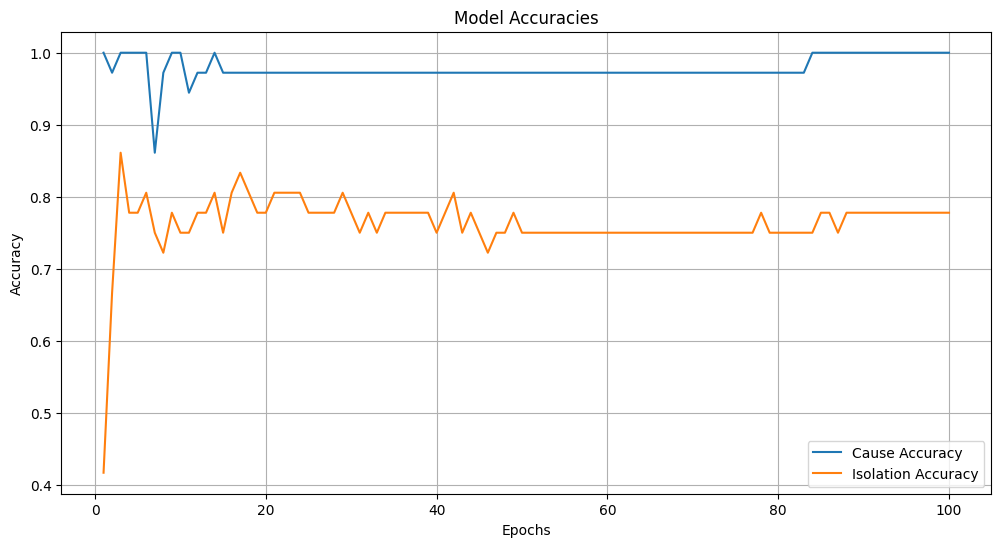

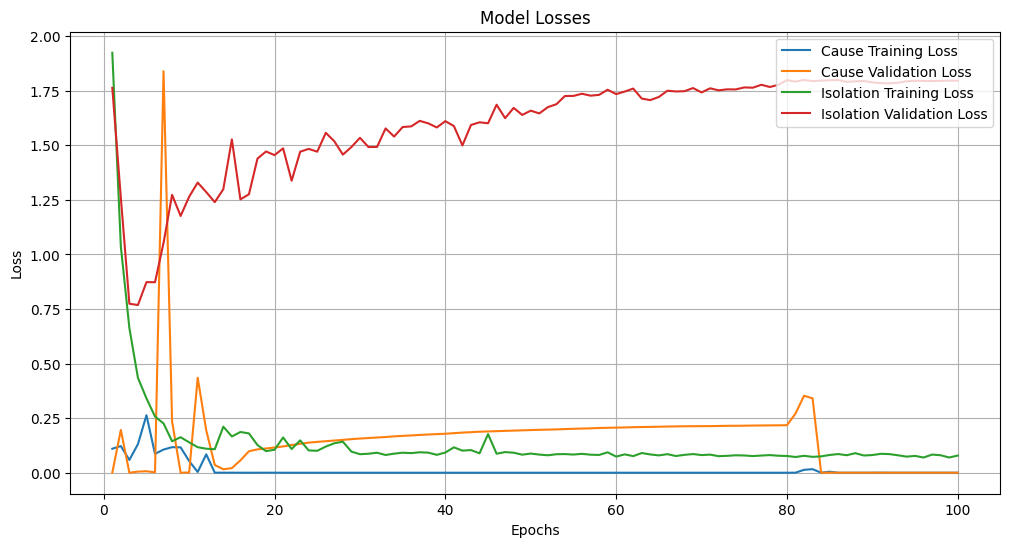

In [ ]:
def plot_training_metrics(cause_trainer, isolation_trainer):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, cause_accuracy, label='Cause Training Accuracy')
    plt.plot(epochs, isolation_accuracy, label='Isolation Training Accuracy') 
    plt.title('Model Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(epochs, cause_eval_loss, label='Cause Validation Loss')
    plt.plot(epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(epochs, isolation_eval_loss, label='Isolation Validation Loss')
    plt.title('Model Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()   
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    train_loss = []
    eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    epochs = []
    


plot_training_metrics(cause_trainer, isolation_trainer)

# 5. Evaluate Model

In [134]:
from sklearn.metrics import classification_report

### evaluating the model on the train set

Evaluating on training set:


100%|██████████| 18/18 [00:01<00:00, 10.15it/s]


Classification Report - Cause:
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         4
    Customer       1.00      1.00      1.00         5
   Equipment       1.00      1.00      1.00        54
   Lightning       1.00      1.00      1.00        18
       Other       1.00      1.00      1.00         4
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00        35
     Vehicle       1.00      1.00      1.00        18
     Weather       1.00      1.00      1.00         3

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142


Classification Report - Isolation Equipment:
                  precision    recall  f1-score   support

         Breaker       1.00      0.94      0.97        65
            CO15       1.00      1.00      1.00        10
          CO15LB       0.88      1.00      

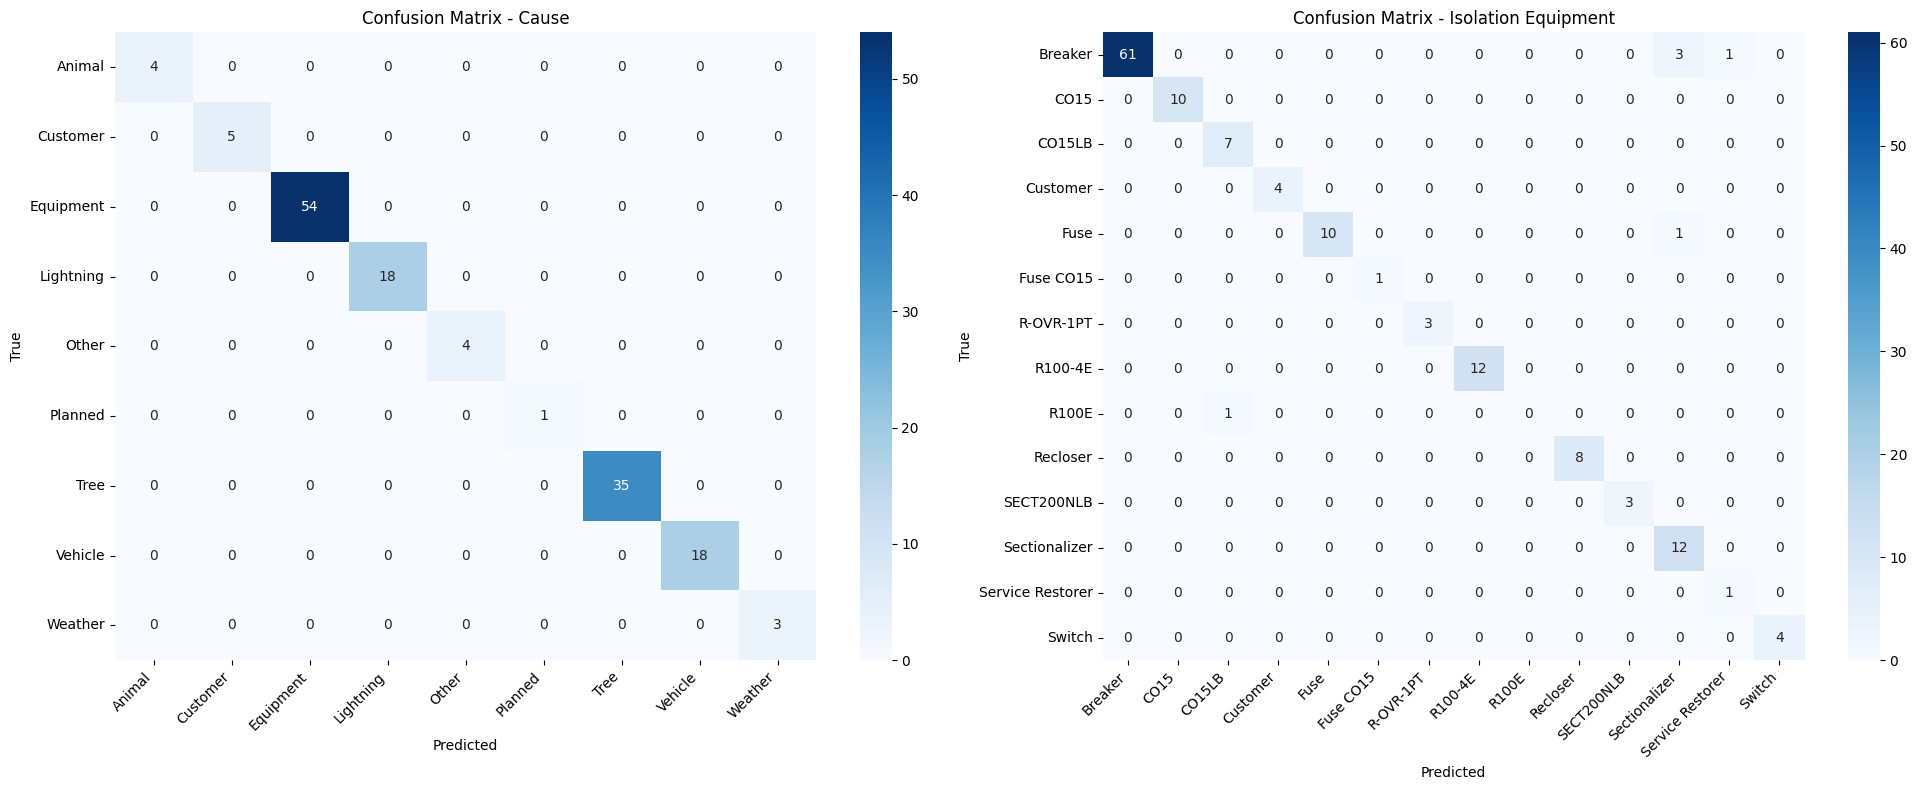

In [138]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on training set
print("Evaluating on training set:")
cause_predictions = cause_trainer.predict(tokenized_train_cause)
isolation_predictions = isolation_trainer.predict(tokenized_train_isolation)

# Extract predictions
cause_preds = np.argmax(cause_predictions.predictions, axis=1)
isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)

# Get true labels
cause_true = df_train['cause_label'].values
isolation_true = df_train['isolation_label'].values

# Get unique labels present in data
unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

# Get class names for present labels
cause_class_names = le_cause.classes_[unique_cause_labels]
isolation_class_names = le_isolation.classes_[unique_isolation_labels]

# Print classification reports with only present classes
print("Classification Report - Cause:")
print(classification_report(
    cause_true, cause_preds,
    labels=unique_cause_labels,
    target_names=cause_class_names,
    zero_division=0
))

print("\nClassification Report - Isolation Equipment:")
print(classification_report(
    isolation_true, isolation_preds,
    labels=unique_isolation_labels,
    target_names=isolation_class_names,
    zero_division=0
))

# Create figure for confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Cause confusion matrix with present labels only
cause_conf_matrix = confusion_matrix(cause_true, cause_preds, labels=unique_cause_labels)
sns.heatmap(cause_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cause_class_names,
            yticklabels=cause_class_names,
            ax=ax1)
ax1.set_title('Confusion Matrix - Cause')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot Isolation Equipment confusion matrix with present labels only
isolation_conf_matrix = confusion_matrix(isolation_true, isolation_preds, labels=unique_isolation_labels)
sns.heatmap(isolation_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=isolation_class_names,
            yticklabels=isolation_class_names,
            ax=ax2)
ax2.set_title('Confusion Matrix - Isolation Equipment')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

✅ Model performs exceptionally well (99% accuracy).
⚠️ Class 8 has poor performance (likely due to an imbalanced dataset or insufficient training examples)

 ### evaluating the model on the test set

100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


Classification Report - Cause:
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Classification Report - Isolation Equipment:
               precision    recall  f1-score   support

      Breaker       0.92      1.00      0.96        11
         CO15       0.00      0.00      0.00         2
       CO15LB       0.00      0.00      0.00         0
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.50      0.67      

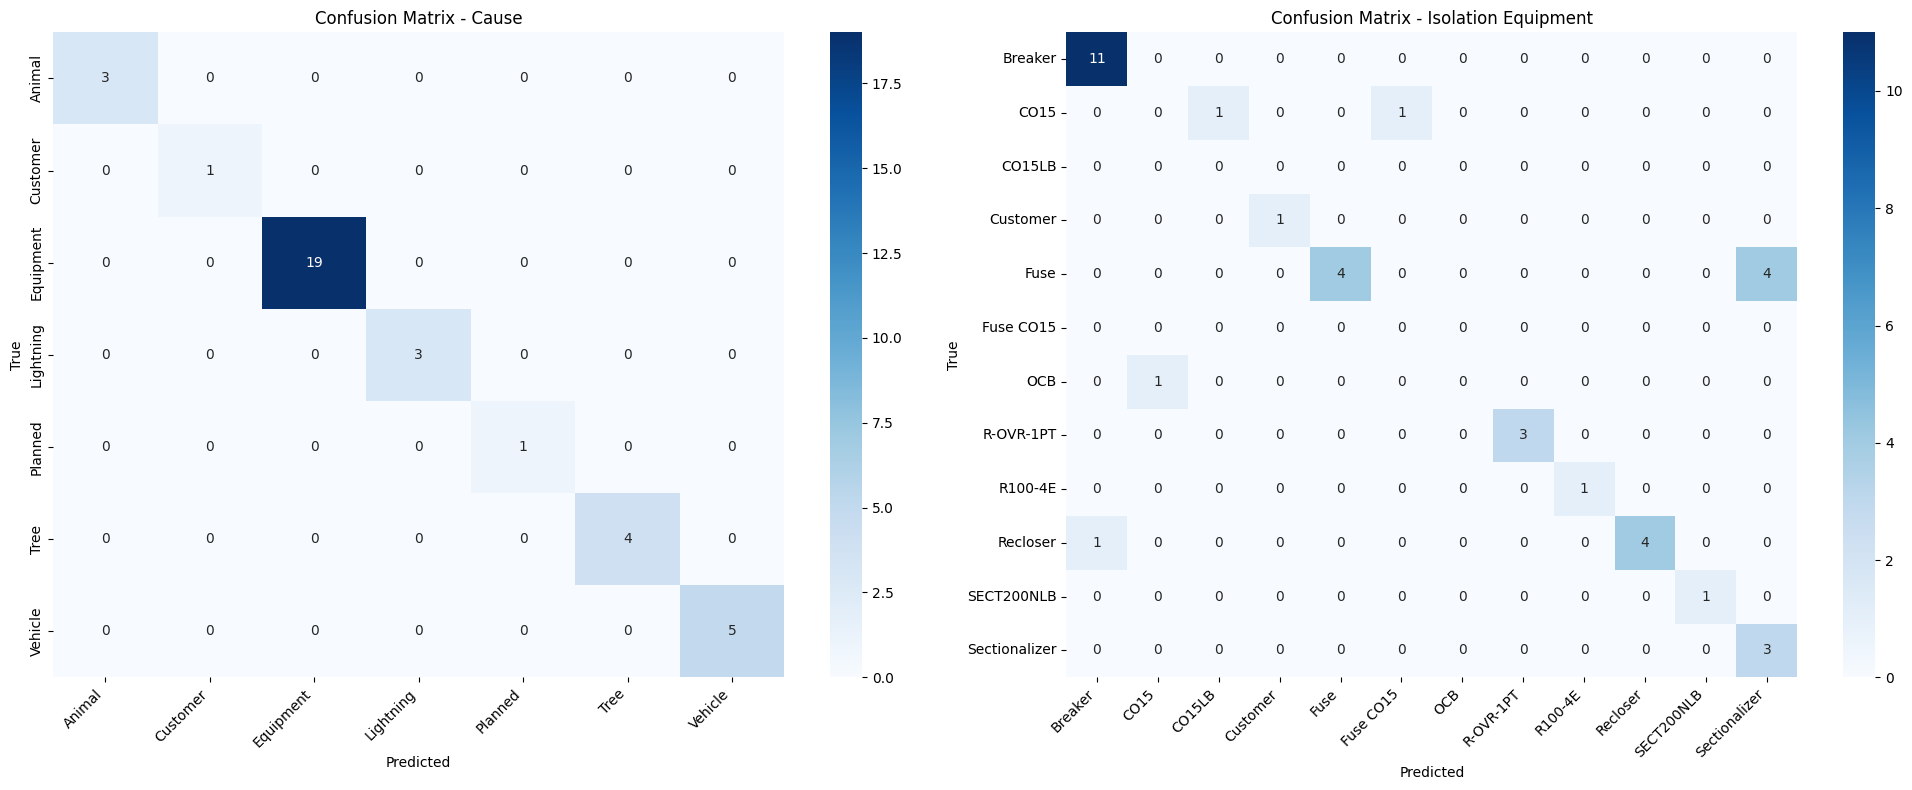

In [139]:
# Get predictions for both models on test set
cause_predictions = cause_trainer.predict(tokenized_test_cause)  # Changed from tokenized_test
isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)  # Changed from tokenized_test

# Extract predictions
cause_preds = np.argmax(cause_predictions.predictions, axis=1)  
isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)

# Get ground truth values
cause_true = df_test['cause_label'].values  # Changed from tolist() for consistency
isolation_true = df_test['isolation_label'].values

# Get unique labels present in test data
unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

# Get class names for present labels
cause_class_names = le_cause.classes_[unique_cause_labels]
isolation_class_names = le_isolation.classes_[unique_isolation_labels]

# Print classification reports with only present classes
print("Classification Report - Cause:")
print(classification_report(
    cause_true, cause_preds,
    labels=unique_cause_labels,
    target_names=cause_class_names,
    zero_division=0
))

print("\nClassification Report - Isolation Equipment:")
print(classification_report(
    isolation_true, isolation_preds,
    labels=unique_isolation_labels, 
    target_names=isolation_class_names,
    zero_division=0
))

# Create figure for confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Cause confusion matrix with present labels only
cause_conf_matrix = confusion_matrix(cause_true, cause_preds, labels=unique_cause_labels)
sns.heatmap(cause_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cause_class_names,
            yticklabels=cause_class_names,
            ax=ax1)
ax1.set_title('Confusion Matrix - Cause')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot Isolation Equipment confusion matrix with present labels only
isolation_conf_matrix = confusion_matrix(isolation_true, isolation_preds, labels=unique_isolation_labels)
sns.heatmap(isolation_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=isolation_class_names,
            yticklabels=isolation_class_names,
            ax=ax2)
ax2.set_title('Confusion Matrix - Isolation Equipment')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Using the saved ticket model for real time application

In [142]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Function to clean input text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

In [ ]:
# User input and classification
text = input("Enter text to classify: ")
cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
print(f"text: {text}")
print(f"Predicted cause: {cause}")
print(f"Predicted isolation: {isolation}")

Predicted cause: Customer
Predicted isolation: CO15LB


In [ ]:
# User input and classification
text = input("Enter text to classify: ")
cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
print(f"text: {text}")
print(f"Predicted cause: {cause}")
print(f"Predicted isolation: {isolation}")

Predicted cause: Equipment
Predicted isolation: Breaker
